# Assignment 1
## EXIST 2023 Task 2, sexism detection

| Student | ID | Email |
|-----------|-----------|-----------|
|  Flavio D'Amato   | 0001169011| flavio.damato@studio.unibo.it       |
|  Luca Andaloro    | 0001168042| luca.andaloro2@studio.unibo.it       |
|  Alessio La Torre | 0001195123| alessio.latorre@studio.unibo.it       |
|  Lorenzo Venturi  | 0001138787| lorenzo.venturi14@studio.unibo.it       |

### Imports

In [7]:
#============= Standard libraries ==============#
import codecs                     
import gc                          
import os                          
import re   
import json                       
import warnings                    
from collections import Counter    
from functools import reduce       
from pathlib import Path           
from typing import Dict,List,OrderedDict,Tuple,Literal,Optional
import math
import copy
import shutil
import gdown

#============= Text nlp utils libraries ========#
import emoji                       
import nltk                        
from nltk import pos_tag            
from nltk.corpus import wordnet,stopwords    
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import WhitespaceTokenizer
from nltk.metrics.distance import edit_distance 

#============= Data manipulations libraries ====#
import numpy as np                
import pandas as pd                
from tqdm import tqdm              
import simplejson as sj            
from datasets import Dataset

#============= Visualization libraries =========#
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.axes
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve

#============= Pytorch libraries ===============#
import torch                       
from torch import nn   
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, TensorDataset

#============= Transformers libraries ==========#
from transformers import(
    AutoTokenizer,                 
    AutoModelForSequenceClassification,  
    DataCollatorWithPadding,       
    Trainer,                       
    TrainingArguments,
    EarlyStoppingCallback    
)

#============= Metrics libraries ===============#
from sklearn.metrics import (
    accuracy_score, 
    f1_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,             
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc,
    PrecisionRecallDisplay,
)
from scipy.stats import mode
from scipy.special import softmax

#============= Word embeddings ==================#
import gensim
import gensim.downloader as gloader


In this cell we define a single configuration dictionary that collects all the main parameters of the project. This helps us keep everything in one place, so we can quickly check or modify device settings, embeddings, model hyperparameters, paths, and seeds without digging through the whole code.


In [ ]:
cfg = {
    #============= Device configuration ============#
    "device":  torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu"),


    #============= Vocabulary params ===============#
    "embedding_dimension": 50,                                   
    "extend_vocabulary": False,                                 # True if the vocabulary used is composed by both glove 
                                                                # and training tokens
    
    "num_labels": 4,                                            


    #============= Paths ===========================#
    "weights_path": Path("./weights/"),
    "similarities_path": Path("./data/similarities.json"),      # Path where are saved top 10 most similar word for all OOV
                                                                # needed to create custom embedding of <UNK> tokens
    "data_path": Path("./data/"),

    #============= Google Drive URLs ===============#
    "data_URL": "https://drive.google.com/drive/folders/1r6pbLsNoXIeJ4QlPxOxprPcwhKRYsbJj?usp=sharing",
    "weights_URL": "https://drive.google.com/drive/folders/1mZzeG9hgyd2idi4Hz0lqVkVh4-Am8Vj3?usp=sharing",

    #============= Embedding params ================#
    "method": "random",                                         # Choice bewtween "random" to have a random embedding
                                                                # "mean" to take mean among "k" most similar words
                                                                # and "average" to take weighted average among "k" most similar words

    "low_random": -0.05,                                        # range parameters for "random" embedding method
    "high_random": 0.05,
    
    "k": 2,                                                     # Number of neighbour words to consider if method is "mean"
    "weights": [0.7,0.3],                                       # Coefficients for the weighted average calculation
    "max_sequence_length": 55,                                  # Max number of tokens in a tweet, Set to 55 after inspecting
                                                                # the lengths histogram on training set

    #============= LSTM Hyperparameters ============#
    "TRAINING_CONFIGURATION_LSTM": {
        "baseline_layers": 1,
        "stacked_layers": 2,
        "bidirectionality": True,

        "hidden_size": 128,
        "dropout": 0.4,
        "lr": 1e-4,
        "epochs": 120,
        "batch_size": 64,
        
        "freeze": True,                                         # if true embedding vectors are not changed during training
    },

    #============ Trasformers parameters ===========#
    'model_card': 'cardiffnlp/twitter-roberta-base-hate',       # Pre trained huggingface model used

    "TRAINING_CONFIGURATIONS_TRANSFORMER": {
                                'learning_rate': 2e-5,
                                'num_train_epochs': 5,
                                'per_device_train_batch_size': 16,
                                'per_device_eval_batch_size': 16,
                                'weight_decay': 0.01,
                                'report_to': 'none',
                                'freeze_layers': True,                                       
                                'from_layer': 8,
                                },
    "logging_steps": 10,                                        # Log training metrics every 'logging_steps' steps
    "load_best_model_at_end": True,                             # Whether to load the best checkpoint automatically at the end of training or last
    "greater_is_better": True,                                  # Higher metric values indicate better performance
    "metric_for_best_model": "eval_f1",                         # Use the evaluation F1 score to determine the best checkpoint
    "dataloader_pin_memory": False,                             # Pinning memory for dataloader 
   

    #============== Ensemble =======================#
    "ensemble_method": 'higher_confidence',                         # Choice between higher_confidence or maj_vote for ensembling models

    #============= Reproducibility =================#
    "seeds": [41,42,43]

}

With this function we can set all the possible sources of randomness when training with different seed configuration

In [9]:
# ----------------SEED CONFIGURATIONS----------------
def set_seed(seed:int) -> None:
    """
    Fix all the possible sources of randomness.

    :param seed: the seed to use.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

And with this function we can download all the necessary files from a public Google Drive folder

In [ ]:
def download_all_files_gdown(path: Path, URL: str) -> None:
    """
    Download all the files and folders from the public Google Drive URL.

    :param path: the path where to save the files.
    :param URL: the URL string of the Google Drive folder.
    """
    os.makedirs(path, exist_ok=True)
    
    gdown.download_folder(
        url=URL,
        output=str(path),
        quiet=False,
        remaining_ok=True
    )

# TASK 1: Corpus


### 1.1 | 1.2 - Download and Load the Data
We download all the datasets from a Google Drive folder and then load the training, validation and test datasets from local JSON files into pandas Dataframes, printing their dimensions and showing the head.

In [ ]:
download_all_files_gdown(cfg['data_path'],cfg["data_URL"])

Retrieving folder contents


Processing file 1qiXNj5IsPH_xjvSTy-qjCbr7RUmb4DAt similarities.json
Processing file 1dtibpud7idmAfCLocu2GJs2MjwHH8IT8 test.json
Processing file 1TQja_ZdKrKBW4mVjyeoK-xu7Yu-_1CN1 training.json
Processing file 1sZIYWP7q6dDGZSxKxEF1W9_u5lDG-Yzh validation.json


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1qiXNj5IsPH_xjvSTy-qjCbr7RUmb4DAt
To: c:\Users\lucad\Desktop\Master\2° Year\Natural Language Processing\Assignments\A1 - Sexism Detection\sEXism-Identification-in-Social-neTworks---Source-Intention\data\similarities.json
100%|██████████| 279k/279k [00:00<00:00, 7.65MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dtibpud7idmAfCLocu2GJs2MjwHH8IT8
To: c:\Users\lucad\Desktop\Master\2° Year\Natural Language Processing\Assignments\A1 - Sexism Detection\sEXism-Identification-in-Social-neTworks---Source-Intention\data\test.json
100%|██████████| 492k/492k [00:00<00:00, 4.49MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TQja_ZdKrKBW4mVjyeoK-xu7Yu-_1CN1
To: c:\Users\lucad\Desktop\Master\2° Year\Natural Language Processing\Assignments\A1 - Sexism Detection\sEXism-Identification-in-Social-neTworks---Source-Intention\data\

In [12]:
train_path = f"{cfg['data_path']}/training.json"
val_path = f"{cfg['data_path']}/validation.json"
test_path = f"{cfg['data_path']}/test.json"

df_train = pd.read_json(train_path, orient="index")
df_val = pd.read_json(val_path, orient="index")
df_test = pd.read_json(test_path, orient="index")

print(f"Training data shape: {df_train.shape}")
print(f"Validation data shape: {df_val.shape}")
print(f"Test data shape: {df_test.shape}")

df_train.head()

Training data shape: (6920, 11)
Validation data shape: (726, 11)
Test data shape: (312, 11)


,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
100001,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


### 1.3 - Labels Aggregation
We create a 'label' column in the datasets by determining the majority vote from 'label_task2' list, handling ties and unknown.

In [13]:
def get_major_vote(labels: list)-> float:
    """
    Find the major vote among all the labels provided.

    :params labels: list of labels assigned to a specific tweet.
        
    :returns
        - The major vote label or nan is a tie or 'UNKNOWN'.
    """
    counts = Counter(labels)
    top2 = counts.most_common(2)
    if (len(top2)>1 and top2[0][1] == top2[1][1]) or top2[0][0]=='UNKNOWN':
        return np.nan
    else:
        return top2[0][0]

df_train['label'] = df_train['labels_task2'].apply(get_major_vote)
df_val['label'] = df_val['labels_task2'].apply(get_major_vote)
df_test['label'] = df_test['labels_task2'].apply(get_major_vote)

df_train.dropna(subset=['label'], inplace=True)
df_val.dropna(subset=['label'], inplace=True)
df_test.dropna(subset=['label'], inplace=True)

print(f"New training shape: {df_train.shape}")
print(f"New validation shape: {df_val.shape}")
print(f"New test shape: {df_test.shape}")

New training shape: (6064, 12)
New validation shape: (630, 12)
New test shape: (280, 12)


### 1.4 - Filter the DataFrame
We filter the dataframe to mantain only english tweets.

In [14]:
df_train_en = df_train[df_train['lang'] == 'en']
df_val_en = df_val[df_val['lang'] == 'en']
df_test_en = df_test[df_test['lang'] == 'en']

print(f"Training data english shape: {df_train_en.shape}")
print(f"Validation data english shape: {df_val_en.shape}")
print(f"Test data english shape: {df_test_en.shape}")

Training data english shape: (2873, 12)
Validation data english shape: (150, 12)
Test data english shape: (280, 12)


### 1.5 - Remove unwanted columns
We remove unwanted columns from the dataframes.

In [15]:
unwanted_cols = ['number_annotators', 'annotators', 'gender_annotators', 'age_annotators', 'labels_task1', 'labels_task2', 'labels_task3', 'split']
df_train_en = df_train_en.drop(columns=unwanted_cols)
df_val_en = df_val_en.drop(columns=unwanted_cols)
df_test_en = df_test_en.drop(columns=unwanted_cols)

df_train_en.head()

,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,-
200002,200002,en,Writing a uni essay in my local pub with a cof...,REPORTED
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,REPORTED
200004,200004,en,@GMB this is unacceptable. Use her title as yo...,-
200005,200005,en,‘Making yourself a harder target’ basically bo...,-


### 1.6 - Encode the label column.
We encode the labels using the mapping given.
```
{
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
```

In [16]:
mapping = {
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}

df_train_en['label'] = df_train_en['label'].map(mapping)
df_val_en['label'] = df_val_en['label'].map(mapping)
df_test_en['label'] = df_test_en['label'].map(mapping)

df_train_en.head()

,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,0
200002,200002,en,Writing a uni essay in my local pub with a cof...,3
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,3
200004,200004,en,@GMB this is unacceptable. Use her title as yo...,0
200005,200005,en,‘Making yourself a harder target’ basically bo...,0


Dataset distribution visualization

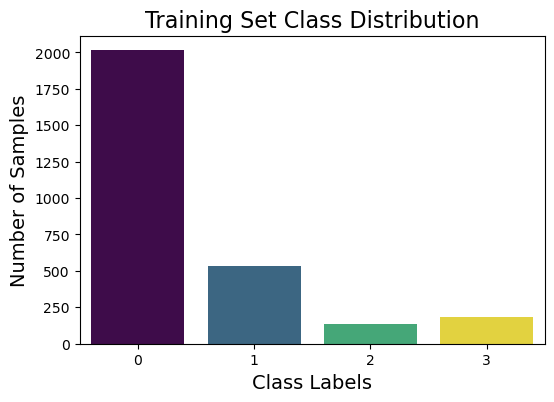

In [17]:
# train set distribution plot
plt.figure(figsize=(6,4))
sns.countplot(x='label',hue='label', data=df_train_en, palette='viridis',legend=False)
plt.title('Training Set Class Distribution', fontsize=16)
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Number of Samples', fontsize=14)
plt.show()

As we can see, the dataset is heavily imbalanced, this needs to be taken care during the training of the models.

# Task2: Data Cleaning


In this cell we define all the small text-cleaning functions we use later in the preprocessing pipeline.


In [18]:
def lower(text: str) -> str:
    """
    Transforms a given text to lower case.

    :param text: the input text.

    :returns
        - lower cased text.
    """
    return text.lower()

def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from the text.

    :param text: the input text.

    :returns
        - the stripped text.
    """
    return text.strip()

def remove_emojis(text: str) -> str:
    """
    Removes all the emojis from the input text.

    :param text: the input text.

    :returns
        - the text without emojis.
    """
    with warnings.catch_warnings():         
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        return emoji.replace_emoji(codecs.decode(text, "unicode_escape"), "")

def remove_hashtags(text: str) -> str:
    """
    Removes all the hashtags from the input text.

    :param text: the input text.
        
    :returns
        - the text without the hashtags.
    """
    return re.sub(r"#\S+", "", text)
 
def remove_mentions(text: str) -> str:
    """
    Removes all the mentions from the input text.
    
    :param text: the input text

    :returns
        - the text without the mentions.
    """
    return re.sub(r"@\S+", "", text)

def remove_URLs(text: str) -> str:
    """
    Removes all the URLs from the input text.
    
    :param text: the input text

    :returns
        - the text without the URLs.
    """
    return re.sub(r"http\S+|www\.\S+", "",text) # it handles both http and https

def remove_special_chars(text: str) -> str:
    """
    Removes all the special characters from the input text.

    :param text: the input text.
    
    :returns
        - the text without the special characters.
    """
    return re.sub(r"[^a-z0-9\s]", "", text)

### Preprocessing pipeline
We define a pipeline of text cleaning functions and apply the pipeline to the 'tweet' column.

In [19]:
PREPROCESSING_PIPELINE = [remove_URLs,
                          remove_emojis,
                          lower,
                          remove_hashtags,
                          remove_mentions,
                          remove_special_chars,
                          strip_text
                          ]

def text_prepare(
    text: str,
    filter_methods: list = None
) -> str:
    """
    It applies a list of pre-processing functions in sequence (reduce), the order is important.
    
    :param text: the input text.
    :param filter_methods: list of the functions to apply
    
    :returns
        - the cleaned text.
    """
    filter_methods = filter_methods \
    if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

print(f"Before text cleaning: {df_train_en['tweet'][200001]}")
df_train_en['tweet_clean'] = df_train_en['tweet'].apply(text_prepare)
df_val_en['tweet_clean'] = df_val_en['tweet'].apply(text_prepare)
df_test_en['tweet_clean'] = df_test_en['tweet'].apply(text_prepare)
print(f"After text cleaning: {df_train_en['tweet_clean'][200001]}")

Before text cleaning: FFS! How about laying the blame on the bastard who murdered her? Novel idea, I know. https://t.co/GI5B45THvJ
After text cleaning: ffs how about laying the blame on the bastard who murdered her novel idea i know


The example above shows that the pipeline worked as we expected, removing what is useless

### Lemmatization

Here we initialize the tokenizer and lemmatizer, define the POS-tag mapping helper, and apply lemmatization to the cleaned tweets in the train, validation, and test sets.


In [20]:
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download("stopwords")

tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def get_wordnet_key(pos_tag)-> str:
    """
    Maps the POS tag to the requested format for the lemmatizer.
    
    :param pos_tag: the POS tag.
    
    :returns
        - the mapped POS tag.
    """
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return 'n'

def lem_text(text: str):
    """
    Lemmatizes the input text.

    :param text: the input text
        
    :returns
        - the lemmatized text.
    """
    tokens = tokenizer.tokenize(text)
    tagged = pos_tag(tokens)
    words = [lemmatizer.lemmatize(word, get_wordnet_key(tag)) 
             for word, tag in tagged]
    return " ".join(words)

# Apply Lemmatization
lem_train_texts = [lem_text(text) 
                   for text in tqdm(df_train_en['tweet_clean'].values,
                                    leave=True,
                                    position=0)]

lem_val_texts = [lem_text(text) 
                   for text in tqdm(df_val_en['tweet_clean'].values,
                                    leave=True,
                                    position=0)]

lem_test_texts = [lem_text(text) 
                  for text in tqdm(df_test_en['tweet_clean'].values,
                                   leave=True,
                                   position=0)]

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\lucad\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lucad\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\lucad\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 280/280 [00:00<00:00, 1733.65it/s]


In [21]:
print(f"Before text lemmatization: {df_train_en['tweet_clean'][200001]}")
df_train_en['tweet'] = lem_train_texts
df_val_en['tweet'] = lem_val_texts
df_test_en['tweet'] = lem_test_texts
print(f"After text lemmatization: {df_train_en['tweet'][200001]}")

Before text lemmatization: ffs how about laying the blame on the bastard who murdered her novel idea i know
After text lemmatization: ffs how about lay the blame on the bastard who murder her novel idea i know


Words like "laying" or "murdered" have been lemmatize to their base form "lay" and "murder", so everything work as it should

# Task 3 -Text Encoding

This function builds the vocabulary we use for the model. We first add the special tokens `<PAD>` and `<UNK>`: the padding token is used to make all sequences the same length due to the fixed input dimension required, while `<UNK>` handles any word that doesn’t appear in the training vocabulary. After that, every unique token from the dataset given in input gets its own index.



In [22]:
def build_vocabulary(
    df: pd.DataFrame
) -> Tuple[Dict[int, str], Dict[str, int], List[str]]:
    """
    Given a dataset, it builds the corresponding word vocabulary.
    
    :param df: dataset from which we want to build the word vocabulary (pandas.DataFrame)
    
    :returns
            - index_to_word: mapping from a vocabulary indices to words.
            - word_to_index: mapping from the words to the vocabulary indices.
            - word_list: list of the unique words forming the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    idx_to_word[0] = "<PAD>"
    idx_to_word[1] = "<UNK>"
    word_to_idx["<PAD>"] = 0
    word_to_idx["<UNK>"] = 1

    curr_idx = 2

    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

And here we build the vocabulary from the training tweets, showing some token examples

In [23]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(df_train_en)
print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')

some_words = [(idx_to_word[idx], idx) for idx in np.arange(10)]
print(f'[Debug] Some words: {some_words}')

100%|██████████| 2873/2873 [00:00<00:00, 382340.81it/s]

[Debug] Index -> Word vocabulary size: 9810
[Debug] Word -> Index vocabulary size: 9810
[Debug] Some words: [('<PAD>', 0), ('<UNK>', 1), ('ffs', 2), ('how', 3), ('about', 4), ('lay', 5), ('the', 6), ('blame', 7), ('on', 8), ('bastard', 9)]


This cell defines a small test function to check that the vocabulary is built correctly. It verifies the consistency of the index–word mappings and ensures that building the vocabulary multiple times on the same data always gives the same result.

We also test the function on a tiny toy dataset just to confirm that the special tokens and the unique words are handled as expected.


In [24]:
def evaluate_vocabulary(
    idx_to_word: Dict[int, str],
    word_to_idx: Dict[str, int],
    word_listing: List[str],
    df: pd.DataFrame,
) -> None:
    """
    Function to evaluate the correctness of a given vocabulary.
    
    :param idx_to_word: mapping from the vocabulary indices to the words.
    :param word_to_idx: mapping from the words to the vocabulary indices
    :param word_listing: list of the unique words forming the vocabulary.
    :param df: dataset from which the vocabulary was built
    """
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

    toy_df = pd.DataFrame.from_dict({
        'tweet': ["all that glitters is not gold",
                 "all in all i like this assignment"]
    })
    _, _, toy_word_listing = build_vocabulary(toy_df)

    toy_valid_vocabulary = set(' '.join(toy_df.tweet.values).split())
    toy_valid_vocabulary.add('<UNK>')
    toy_valid_vocabulary.add('<PAD>')

    assert set(toy_word_listing) == toy_valid_vocabulary

In [25]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df_train_en)
print("Evaluation completed!") 

Vocabulary evaluation...


100%|██████████| 2/2 [00:00<?, ?it/s]

Evaluation completed!


In [26]:
idx_to_word_validation, word_to_idx_validation, word_listing_validation = build_vocabulary(df_val_en)
evaluate_vocabulary(idx_to_word_validation, word_to_idx_validation, word_listing_validation, df_val_en)

100%|██████████| 2/2 [00:00<?, ?it/s]


Here we save the vocabulary to a JSON file so we can easily inspect it

In [27]:
# vocabulary local saving
os.makedirs(f"{cfg['data_path']}/vocabularies", exist_ok=True)
vocab_path = Path.cwd().joinpath('data', 'vocabularies', 'vocab_train_en.json')

print(f"Saving vocabulary to {vocab_path}")
with vocab_path.open(mode='w') as f:
    sj.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Saving vocabulary to c:\Users\lucad\Desktop\Master\2° Year\Natural Language Processing\Assignments\A1 - Sexism Detection\sEXism-Identification-in-Social-neTworks---Source-Intention\data\vocabularies\vocab_train_en.json
Saving completed!


#### Embeddings


This function loads a pre-trained embedding model using Gensim. For our setup we only support GloVe, and the embedding dimension must match one of the available versions. If the model can’t be loaded, we print some hints about the valid dimensions.


In [28]:
def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider.

    :return
        - pre-trained word embedding model (gensim KeyedVectors object).
    """
    download_path = ""
    
    if model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [29]:
# we embed the words via pre-trained Glove embeddings
embedding_model = load_embedding_model(model_type="glove",
                                       embedding_dimension=cfg["embedding_dimension"])

In [30]:
print(len(embedding_model))
print(list(embedding_model.key_to_index)[:100])

400000
['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after', 'new', 'been', 'also', 'we', 'would', 'two', 'more', "'", 'first', 'about', 'up', 'when', 'year', 'there', 'all', '--', 'out', 'she', 'other', 'people', "n't", 'her', 'percent', 'than', 'over', 'into', 'last', 'some', 'government', 'time', '$', 'you', 'years', 'if', 'no', 'world', 'can', 'three', 'do', ';', 'president', 'only', 'state', 'million', 'could', 'us', 'most', '_', 'against', 'u.s.']


With this function we extend our training vocabulary by adding all the tokens that appear in the GloVe model but not in our dataset. For the main experiments we only use the vocabulary built from the training tweets, and this extended version is included just as an extra exploration.


In [31]:
def extend_vocabulary_with_glove(
    idx_to_word: Dict[int, str],
    word_to_idx: Dict[str, int],
    glove_model: gensim.models.KeyedVectors
) -> Tuple[Dict[int, str], Dict[str, int], List[str]]:
    """
    It extends a vocabulary with the words present in a pre-trained GloVe model.
    
    :param idx_to_word: the mapping from the vocabulary indices to the words.
    :param word_to_idx: the mapping from the words to the vocabulary indices.
    :param glove_model: pre-trained GloVe model.
    
    :returns
        - the updated idx_to_word mapping.
        - the updated word_to_idx mapping.
        - the updated list of unique words forming the vocabulary.
    """
    curr_idx = len(idx_to_word)
 
    for word in tqdm(glove_model.key_to_index.keys()):
        if word not in word_to_idx:
            word_to_idx[word] = curr_idx
            idx_to_word[curr_idx] = word
            curr_idx += 1
 
    word_listing = list(idx_to_word.values())
 
    return idx_to_word, word_to_idx, word_listing

In [32]:
if cfg["extend_vocabulary"]:
    idx_to_word, word_to_idx, word_listing = extend_vocabulary_with_glove(idx_to_word, word_to_idx, embedding_model)
    print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
    print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')

##### OOV terms
Here we check how many words training vocabulary doesn't have among validation vocabulary and pre-trained embedding model. This gives us an idea of the OOV rate and helps understand how often the `<UNK>` token will be used.

In [33]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)


In [34]:
def check_OOV_terms(source_vocabulary: set[str],
                    target_vocabulary: set[str]):
    """
    Checks differences between two vocabularies in order to highlight
    out-of-vocabulary terms.

    :param source_vocabulary: vocabulary to be checked (set)
    :param target_vocabulary: reference vocabulary (set)

    :return
        - list of OOV terms
        - percentage of OOV terms (float, 2 decimal digits)
    """
    oov_terms = list(source_vocabulary.difference(target_vocabulary))
    oov_percentage = round((len(oov_terms) * 100.0) / len(source_vocabulary), 2)

    return oov_terms, oov_percentage


We transform our list of vocabulary terms into set in order to use the function defined above to check OOV terms

In [35]:
word_listing_validation = set(word_listing_validation)
word_listing_training = set(word_listing)
word_listing_embedding_model = set(embedding_model.key_to_index.keys())
union_voc = word_listing_embedding_model.union(word_listing_training)

OOV between validation and training vocabulary


In [36]:
oov_terms, oov_percentage = check_OOV_terms(word_listing_validation, word_listing_training)
print("OOV terms:", list(oov_terms)[:10])
print(f"Percentage of OOV words between validation and training: {len(oov_terms)} ({oov_percentage:.2f} %)")


OOV terms: ['gcse', 'observer', 'uroktor', 'oe', 'cumming', 'ncpr', 'boogieman', '68', 'niece', '18192021']
Percentage of OOV words between validation and training: 340 (23.34 %)


OOV between pre-trained embedding model and training vocabulary.


In [37]:
oov_terms, oov_percentage = check_OOV_terms(word_listing_training, word_listing_embedding_model)
print("OOV terms:", list(oov_terms)[:10])
print(f"Total OOV terms between pre-trained embedding model and training vocabulary: {len(oov_terms)} ({oov_percentage:.2f}%)")

OOV terms: ['suckand', '1firstly', 'winthrops', 'fullyarticulated', 'doorsbut', 'mystiqueor', 'womenthis', 'illnessesviruses', 'partynextdoor', 'turkeh']
Total OOV terms between pre-trained embedding model and training vocabulary: 1835 (18.71%)


OOV between train_vocab + glove and validation


In [38]:
oov_terms, oov_percentage = check_OOV_terms(word_listing_validation, union_voc)
print("OOV terms:", list(oov_terms)[:10])
print(f"Percentage of OOV words between validation and union of training + GloVe: {oov_percentage} %")

OOV terms: ['tetsucabra', 'herselfangela', '18yearold', 'girlyoure', 'terfism', 'uroktor', 'fordward', 'camui', 'impressionenforeigner', 'accepatnce']
Percentage of OOV words between validation and union of training + GloVe: 6.93 %


After inspecting OOV terms we can easily state that the majority of them are due to typos or words not clearly separated with a space, and this can lead to a very difficult task especially when the words that are essential in order to do classification are recognized as OOV

##### Handling OOV terms
Here we define some helper functions to handle OOV tokens more efficiently. We precompute the Levenshtein-distance similarities between OOV terms from our training vocabulary and all tokens in the GloVe vocabulary, keep only the top-10 closest ones, and save everything to a JSON file. This is done offline once to avoid recomputing these expensive similarities every time; later, we can use the stored neighbours to build custom embeddings for OOV tokens (e.g. using mean or weighted mean over the k most similar words) or assigning purely random vectors.


In [39]:
def load_from_json(filepath: Path) -> Dict:
    """
    It load a dictionary from a JSON file

    :param filepath: the path to the JSON file

    :returns:
        - a dictionary loaded from the JSON file.
    """
    similarities = {}

    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            similarities = json.load(f)

    return similarities

def store_into_json(filepath: Path, data: Dict):
    """
    It stores a dictionary into a JSON file

    :param filepath: the path to the JSON file
    :param data: the dictionary to store
    """
    filepath.parent.mkdir(parents=True, exist_ok=True)
    with open(filepath, 'w') as f:
        json.dump(data, f)

def compute_token_similarities(token:str, glove_tokens: gensim.models.keyedvectors.KeyedVectors):
    """
    It computes the similarity scores between a given token
    and all tokens in the GloVe embeddings using the edit distance.

    :param token: the input token.
    :param glove_tokens: the GloVe embeddings.

    :returns:
        - a list of tuples containing the tokens and their similarity scores sorted by the similarity
    """
    similarity_scores = {}
    
    for word in glove_tokens.key_to_index:
        similarity_score = edit_distance(token, word, substitution_cost=2) # Levenshtein distance
        similarity_scores[word] = similarity_score

    sorted_similarities = sorted(similarity_scores.items(), key=lambda x: x[1])
    top_10 = sorted_similarities[:10]
    print(top_10)
    return top_10

In [40]:
filepath = cfg["similarities_path"]
similarities = load_from_json(filepath)

for word, idx in tqdm(word_to_idx.items()):
    if word not in embedding_model.key_to_index and word not in similarities and word not in ['<PAD>', '<UNK>']:
        top_10 = compute_token_similarities(word, embedding_model)
        similarities[word] = top_10
        store_into_json(filepath, similarities)

100%|██████████| 9810/9810 [00:00<00:00, 1962422.96it/s]


In [41]:
def get_top_k_similar(token: str, filepath: Path, k: int):
    """
    It retrieves the top-k similar tokens for a given token
    from a specific dictionary in a JSON.

    :param token: the input token
    :param filepath: the path to the JSON file containing the similarity data.
    :param k: the number of top similar tokens to retrieve

    :returns:
        - a list of the top k similar tokens
    """
    if k > 10 or k < 1:
        print("Invalid parameter: k, please insert a value between 2..10")
        return
    similarities_dict = load_from_json(filepath)
    top_k_similar = np.array(similarities_dict[token][:k]) # returns [['token1', x], ['token2', y], ...] where x, y are similarity scores
    top_k_similar_tokens = top_k_similar[:, 0]
    return top_k_similar_tokens


def custom_embedding(token: str, embedding_model: gensim.models.keyedvectors.KeyedVectors, dictionary_path: Path, method: Literal["random", "mean", "average"], k: int = None, weights: list = None):
    """
    It computes a custom embedding for a token, randomly or as mean of similar top-k words

    :param token: the input token.
    :param embedding_model: the pre-trained embedding model.
    :param dictionary_path: the path to the JSON file containing similarity data.
    :param method: method to compute the custom embedding -> random or mean.
    :param k: number of the similar words to consider if method is the mean.
    :param weights: list of k weights for the weighted average.

    :returns:
        - the custom embedding vector
    """
    if method == "random":
        custom_emb = np.random.uniform(low=cfg["low_random"], high=cfg["high_random"], size=cfg["embedding_dimension"])
    elif method== "mean":
        top_k_similar = get_top_k_similar(token, dictionary_path, k)
        top_k_embeddings = embedding_model[top_k_similar]
        custom_emb = np.mean(top_k_embeddings, axis=0)
    elif method== "average":
        top_k_similar = get_top_k_similar(token, dictionary_path, k)
        top_k_embeddings = embedding_model[top_k_similar]
        custom_emb = np.average(top_k_embeddings, axis=0, weights=weights)
    
    return custom_emb

This function builds the embedding matrix for our vocabulary using the chosen pre-trained model. For tokens already present in the embedding model we simply load their vector, while for missing ones we fall back to our custom OOV embedding strategy (using the precomputed similarities or the random method). Special tokens like `<PAD>` and `<UNK>` get their own fixed embeddings. In the end we return both the full matrix and a word-to-vector mapping.


In [42]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           oov_method: Literal["random", "mean", "average"]):
    """
    Builds the embedding matrix of a specific dataset given 
    a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector 
        to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((len(word_to_idx), embedding_dimension), dtype=np.float32)
    word_to_emb = {}
    similarities_path = cfg["similarities_path"]

    for word, idx in tqdm(word_to_idx.items()):
        try:
            if word == '<PAD>':
                embedding_vector = np.zeros_like((embedding_dimension))
            elif word == '<UNK>':
                embedding_vector = np.ones_like((embedding_dimension))
            else:
                embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = custom_embedding(word, embedding_model, similarities_path, method=oov_method, k=cfg["k"], weights=cfg["weights"])

        embedding_matrix[idx] = embedding_vector
        word_to_emb[word] = embedding_vector

    return embedding_matrix, word_to_emb

In [43]:
# we build the embedding matrix of the training vocabulary
emb_matrix, word_to_emb = build_embedding_matrix(embedding_model, cfg["embedding_dimension"], word_to_idx, cfg["method"])

100%|██████████| 9810/9810 [00:00<00:00, 556306.83it/s]


In [44]:
# Visualize the embedding matrix
print(np.round(emb_matrix[:3],3))

[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
   1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
   1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
   1.     1.     1.     1.     1.     1.     1.     1.     1.     1.
   1.     1.     1.     1.     1.     1.     1.     1.     1.     1.   ]
 [-0.155 -0.647  0.673 -0.433 -0.204 -0.174  1.094 -0.405 -0.846 -1.025
   1.326 -0.54  -0.608  0.492 -1.029  0.029 -0.471  0.547  0.865  0.145
  -1.508 -0.541 -0.469  0.534 -0.237  1.013  0.173 -0.26  -0.552  0.86
   0.2    0.976 -0.635  0.854 -1.246  0.735  0.726 -0.221 -0.1    1.481
   1.205 -0.008

With the function below we substitute all the OOV words of validation and test set with the < UNK > token

In [45]:
def handle_unk(sentence: str, word_to_emb: Dict):
    """
    It handle the <UNK> tokens.
    :param sentence: the input sentence.
    :param word_to_emb: the word to embedding mapping.
    :returns:
        - the sentence with <UNK> tokens.
    """
    tokens = sentence.split()
    tweet = [token if token in word_to_emb.keys() else "<UNK>" for token in tokens]
    return ' '.join(tweet)

print(df_val_en['tweet'][400001])
df_val_en['tweet'] = df_val_en['tweet'].apply(lambda tweet: handle_unk(tweet, word_to_emb))
df_test_en['tweet'] = df_test_en['tweet'].apply(lambda tweet: handle_unk(tweet, word_to_emb))
print(df_val_en['tweet'][400001])

you should smile more love just pretend youre a tory open a food bank be only live through the bad in live memory so it all a bit of a giggle cheer up darling it might never happen
you should smile more love just pretend youre a tory open a food <UNK> be only live through the bad in live memory so it all a bit of a <UNK> cheer up darling it might never happen


In [46]:
print(df_test_en['tweet'][400187])

sex a in gender harassment be what they be <UNK>


These functions reduce the embedding space to two dimensions using t-SNE and visualize the result. We can also highlight specific words to see where they lie in the space compared to the rest of the vocabulary.


In [47]:
def reduce_tSNE(input_emb: np.ndarray) -> np.ndarray:
    """
    It applies the t-SNE dim. reduction to the input embeddings.

    :param embeddings: the input embeddings.

    :returns:
        - the reduced embeddings.
    """
    print("Reduction via t-SNE...")
    tsne = TSNE(n_components=2,max_iter=1000,metric='cosine')
    reduced = tsne.fit_transform(input_emb)
    print("t-SNE reduction is completed")

    return reduced

def visualize_embeddings(embeddings: np.ndarray,
                         word_to_idx: Optional[Dict[str, int]] = None,
                         words: Optional[List[str]] = None
                         )->None:
    """
    It visualizes the input embeddings via t-SNE reduction.
    :param embeddings: the input embeddings.
    :param word_to_idx: the word to index mapping.
    :param words: list of words to highlight.
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))

    if words:
        word_indexes =np.array([word_to_idx[w] for w in words if w in word_to_idx])
        other_indexes =np.setdiff1d(np.arange(embeddings.shape[0]),word_indexes)

        ax.scatter(embeddings[other_indexes,0],embeddings[other_indexes,1],
                   alpha=0.1, c='blue')
        ax.scatter(embeddings[word_indexes,0],embeddings[word_indexes,1],
                   alpha=1.0,c='red', edgecolors='r',s=1000)

        for w, idx in zip(words,word_indexes):
            x, y = embeddings[idx]
            ax.annotate(w,xy=(x,y),fontsize=12,weight='bold',color='darkred')
    else:
        ax.scatter(embeddings[:,0], embeddings[:, 1],alpha=0.1,c='blue')

    # we set the limit of axes to reduce disstortions from outliers
    x_min,x_max = np.min(embeddings[:,0]),np.max(embeddings[:,0])
    y_min,y_max = np.min(embeddings[:,1]),np.max(embeddings[:,1])
    ax.set_xlim(x_min-0.5,x_max+0.5)
    ax.set_ylim(y_min-0.5,y_max+0.5)
    ax.set_title("t-SNE embedding visualization",fontsize=16)
    plt.show()

Reduction via t-SNE...
t-SNE reduction is completed


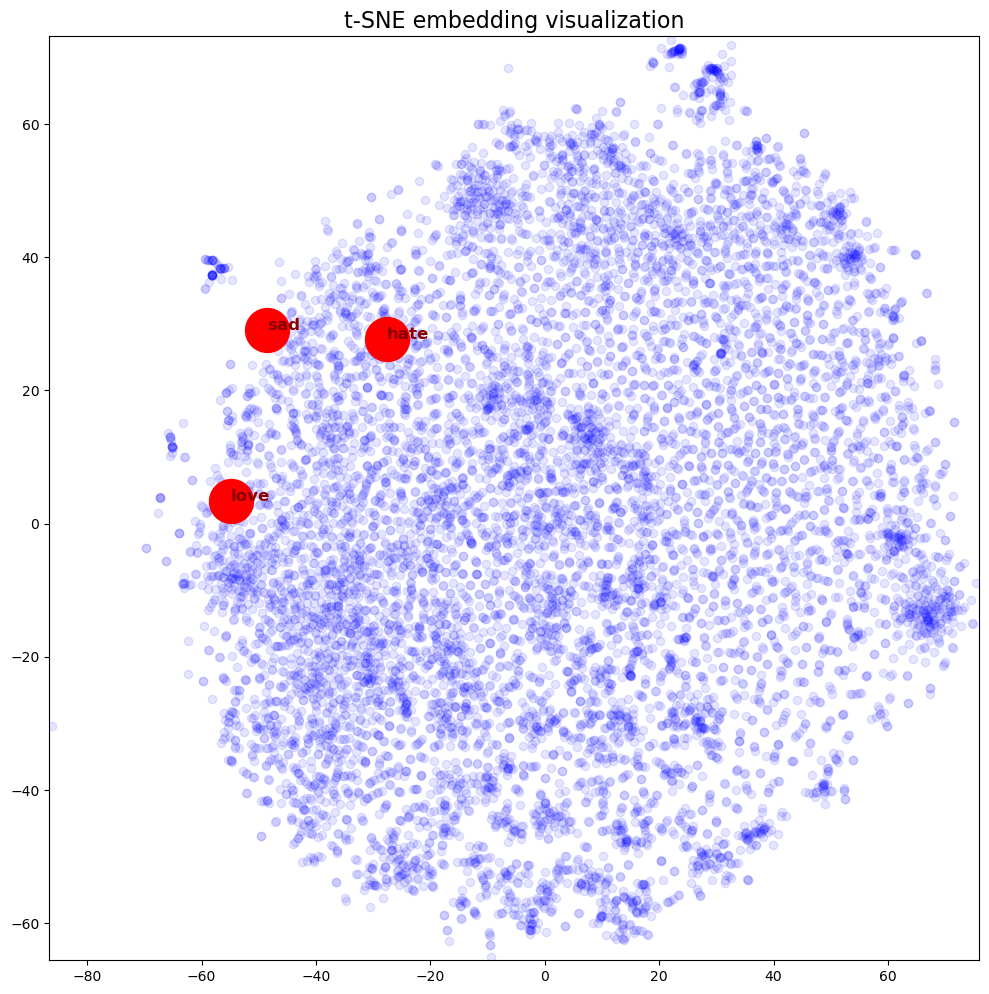

In [48]:
visualize_embeddings(reduce_tSNE(emb_matrix), word_to_idx, words=['hate','love','sad'])

From the plot we can see that the highlighted words (“love”, “hate”, “sad”) end up relatively close to each other in the 2D space. This makes sense, since their embeddings capture sentiment-related meaning, so t-SNE tends to place them in the same region.


# Task 4 - Model definition


In [49]:
# we check the maximum length of the tweets in the train set
lengths = []
for sentence in df_train_en.tweet.values:
    lengths.append(len(sentence.split()))

print(f"Max length: {max(lengths)}")

Max length: 62


Here we check the length distribution in order to establish the max sequence lenght that the model can accept in input

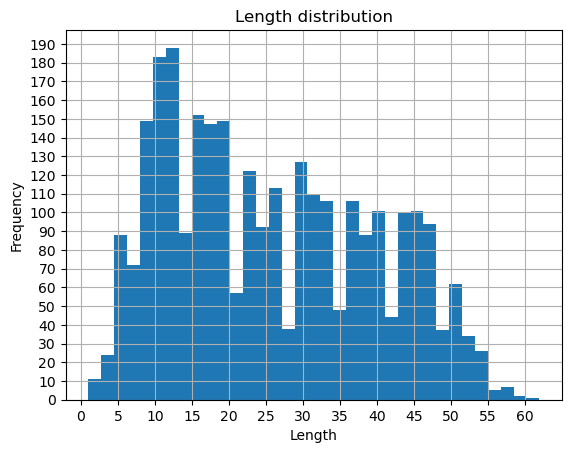

In [50]:
plt.hist(lengths, bins=35)
plt.grid()
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Length distribution")
plt.xticks(np.arange(0, max(lengths)+1, 5))
plt.yticks(np.arange(0, plt.gca().get_ylim()[1]+1, 10))
plt.show()

From the histogram above we decided to put 55 as max sequence (defined in cfg for simplicity) since having smaller sequences can reduce the training time and we noticed that it also improved performances despite some tweets are cut.

In order to put all sentences to the same lenght we needed to insert padding tokens to those tweets that didn't reach the max sequence length.

Here we define the function to handle this tweets

In [51]:
def pad_tweet(tweet: str, max_sequence_length: int) -> str:
    """
    Pads a tweet to a fixed length.
 
    :param tweet: tweet to be padded (list)
 
    :returns:
        - padded tweet
    """
    tweet = tweet.split()
    i = len(tweet)
    while i < max_sequence_length:
        tweet.append('<PAD>')
        i = i + 1
    return ' '.join(tweet[:max_sequence_length])

df_train_en.tweet = df_train_en.tweet.apply(lambda tweet: pad_tweet(tweet, cfg["max_sequence_length"]))
df_val_en.tweet = df_val_en.tweet.apply(lambda tweet: pad_tweet(tweet, cfg["max_sequence_length"]))
df_test_en.tweet = df_test_en.tweet.apply(lambda tweet: pad_tweet(tweet, cfg["max_sequence_length"]))

In [52]:
print(df_train_en['tweet'][200001])

ffs how about lay the blame on the bastard who murder her novel idea i know <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


Here we convert each cleaned tweet into its sequence of indices using the vocabulary mapping. Every token is replaced by its corresponding integer ID, preparing the data for the models that work with numerical inputs.


In [53]:
def token_to_idx(sentence: str, word_to_idx: Dict) -> List[int]:
    """
    Function to map a sentence of tokens to its corresponding indices.

    :param sentence: the input sentence
    :param word_to_idx: the word to index mapping
    
    :returns:
        - the list of indices corresponding to the input sentence
    """
    tokens=sentence.split()
    tweet=[]
    for token in tokens:
        tweet.append(word_to_idx[token])
    return tweet

train_idx = df_train_en['tweet'].apply(lambda tweet: token_to_idx(tweet, word_to_idx))
val_idx = df_val_en['tweet'].apply(lambda tweet: token_to_idx(tweet, word_to_idx))
test_idx = df_test_en['tweet'].apply(lambda tweet: token_to_idx(tweet, word_to_idx))

### LSTM model definition

We turn the embedding matrix into a PyTorch tensor so it can be used directly as the weight matrix for the embedding layer.


In [54]:
emb_weights = torch.tensor(emb_matrix, dtype=torch.float32)

This class defines our LSTM model for tweet classification. We load the pre-trained embeddings, pass the token sequences through a multi-layer (optional) bidirectional LSTM, and use the last hidden state to feed a final linear layer that outputs the class logits.


In [55]:
class LSTM_model(nn.Module):
    def __init__(self,emb_dimension: int, emb_weights: torch.Tensor, seq_length: int, n_layers: int, num_labels: int, training_config: dict):
        """
        :param emb_dimension: the length of the embedding of each token.
        :param emb_weights: the tensor containing all the embeddings of the tokens.
        :param seq_length: the length of the input sentence.
        :param n_layers: the number of LSTM layers.
        :param num_labels: the number of the labels of the classification task.
        :param training_config: the dictionary containing all the parameters for the LSTM model.
        """
        super(LSTM_model, self).__init__()

        self.seq_length = seq_length
        self.hidden_size = training_config["hidden_size"]
        self.n_layers = n_layers
        self.bidirectionality = training_config["bidirectionality"]
        self.num_directions = 2 if self.bidirectionality else 1

        # Embedding Layer
        self.embedding = nn.Embedding(
            num_embeddings = len(emb_weights),
            embedding_dim = emb_dimension,
            padding_idx = 0
        )
        
        # Use of pre-trained embeddings
        self.embedding = nn.Embedding.from_pretrained(emb_weights,freeze=training_config["freeze"],padding_idx=0)

        # BILSTM Layer
        self.bilstm = nn.LSTM(
            input_size = emb_dimension,
            hidden_size = self.hidden_size,
            num_layers = n_layers,
            bias = True,
            batch_first= True,
            dropout = training_config["dropout"] if n_layers > 1 else 0,
            bidirectional =  self.bidirectionality
        )

        # Dense Layer
        self.fc = nn.Linear(self.hidden_size * self.num_directions,num_labels)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers * self.num_directions, x.size(0), self.hidden_size).to(cfg["device"])
        c0 = torch.zeros(self.n_layers * self.num_directions, x.size(0), self.hidden_size).to(cfg["device"])

        embedded = self.embedding(x)
        output, _ = self.bilstm(embedded, (h0,c0))
        output = self.fc(output[:,-1,:])
        return output

Earlier we noticed the strong class imbalance in the dataset and mentioned that we would handle it during training. Before running the LSTM, we now test a few weighting strategies to see how different methods adjust the class weights. The functions below compute and compare several options so we can pick the one that best fits our setup.


In [56]:
def get_weights_distribution(df: pd.DataFrame, method: Literal["sqrt_inverse", "balanced", "log_smoothed"]):
    """
    Compute the class weights distribution to handle class imbalance
    
    :param df: DataFrame containing the data
    :param method: Weighting method to use
    :returns: Tensor of class weights
    """
    class_counts = df['label'].value_counts().sort_index()
    total_samples = len(df)
    num_classes = len(class_counts)
    class_weights = []
            
    if method == "sqrt_inverse":
        # Square root of inverse frequency (even less accentuated)
        for count in class_counts:
            class_weight = total_samples / count
            class_weights.append(math.sqrt(class_weight))

    elif method == "balanced":
        # Sklearn's balanced approach
        for count in class_counts:
            class_weights.append(total_samples / (num_classes * count))
            
    elif method == "log_smoothed":
        # Log with smoothing
        for count in class_counts:
            class_weight = total_samples / count
            class_weights.append(math.log(class_weight + 1)) 
            
    return torch.tensor(class_weights, dtype=torch.float)

Class distribution: [2014, 537, 138, 184]

Weighting method comparison:
------------------------------------------------------------
sqrt_inverse   : ['1.194', '2.313', '4.563', '3.951']
balanced       : ['0.357', '1.338', '5.205', '3.904']
log_smoothed   : ['0.886', '1.848', '3.083', '2.810']


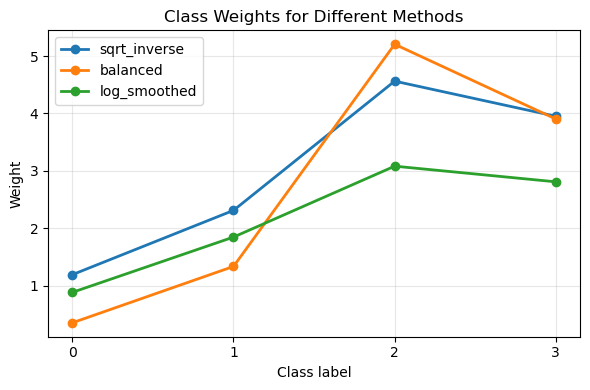

In [57]:
def compare_weighting_methods(df: pd.DataFrame) -> Dict[str, List[float]]:
    """
    Compares different class weighting methods and visualizes the
    resulting weight distributions.

    :param df: DataFrame containing the data and labels.

    :returns:
        - dictionary mapping each method name to its list of class weights.
    """
    methods = ["sqrt_inverse", "balanced", "log_smoothed"]

    class_counts = df['label'].value_counts().sort_index()
    print(f"Class distribution: {class_counts.tolist()}\n")
    print("Weighting method comparison:")
    print("-" * 60)

    results = {}
    for method in methods:
        try:
            weights = get_weights_distribution(df, method)
            results[method] = weights.tolist()
            formatted = [f"{w:.3f}" for w in weights.tolist()]
            print(f"{method:15}: {formatted}")
        except Exception as e:
            print(f"Method not elegible")

    # Plot class weights for each method
    x = range(len(class_counts))
    plt.figure(figsize=(6, 4))

    for method, weights in results.items():
        plt.plot(x, weights, marker='o', linewidth=2, label=method)

    plt.title("Class Weights for Different Methods")
    plt.xlabel("Class label")
    plt.ylabel("Weight")
    plt.xticks(list(x))
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results

comparison_results = compare_weighting_methods(df_train_en)

In order not to be too aggressive with weights we decided to use the sqrt_inverse weighting method 

Here we set up the weighted cross-entropy loss using the chosen class weights to deal with class imbalance, and define the `evaluate` and `train` routines for our LSTM model. The `evaluate` function runs the model on a given loader and returns loss and macro precision/recall/F1, while `train` performs the training loop and tracks how the model behaves on both validation and test sets.


In [58]:
# Loss function
criterion = nn.CrossEntropyLoss(weight=get_weights_distribution(df_train_en,"sqrt_inverse")).to(cfg["device"])

def evaluate(model: LSTM_model, loader: DataLoader) -> dict:
    """
    Function for evaluating the model on a specific data loader

    :param model: the model to evaluate.
    :param loader: the data loader to evaluate on.

    :returns:
        - the value of the average loss\n
        - the precision value\n
        - the recall value\n
        - the f1_score\n
        - the list of true values\n
        - the list of predicted values\n
        - the list of confidence score for each predicted value\n
    """
    model.eval()
    val_loss, total = 0.0,0
    predicted_val, true_val, confidences = [],[],[]
    with torch.no_grad():
        for data, targets in loader:

            data,targets = data.to(cfg["device"]), targets.to(cfg["device"])

            scores = model(data)
            loss = criterion(scores, targets)

            val_loss += loss.item() * data.size(0)
            probs = torch.softmax(scores, dim=1)
            conf, preds = torch.max(probs, dim=1)
            
            predicted_val.append(preds)
            true_val.append(targets)
            confidences.append(conf)

            total += targets.size(0)
   
    true_val=torch.cat(true_val, dim=0).cpu().numpy()
    predicted_val=torch.cat(predicted_val, dim=0).cpu().numpy()
    
    avg_loss = val_loss / total
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_val, predicted_val, average="macro", zero_division=0)

    return {
        "avg_loss": avg_loss,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
        "true_val": true_val,
        "predicted_val": predicted_val,
        "confidences": confidences
    }

def train(model: LSTM_model, model_name: str, seed: int, train_loader: DataLoader, val_loader: DataLoader, test_loader: DataLoader, training_config: dict) -> dict:
    """
    Function to train a specific model and evaluating it on the validation set and test set.

    :param model: the model to train.
    :param model_name: the name of the model.
    :param seed: the seed for the reproducibility.
    :param train_loader: the training data loader.
    :param val_loader: the validation data loader.
    :param test_loader: the test data loader.
    :param training_config: the dictionary containing all the parameters for the LSTM model.

    :returns:
        - the list of the value of the average training loss\n
        - the list of the value of the average validation loss\n
        - the list of precision values of the validation set\n
        - the list of recall values of the validation set\n
        - the list of f1-score values of the validation set\n
        - the list of precision values of the test set\n
        - the list of recall values of the test set\n
        - the list of f1-score values of the test set\n
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=training_config["lr"])
    #optimizer = torch.optim.AdamW(model.parameters(), lr=training_config["lr"], weight_decay=0.001)

    # scheduler = MultiStepLR(
    #     optimizer,
    #     milestones=[50, 70, 85],
    #     gamma=0.4 
    # )

    train_losses = []
    val_losses,val_precisions,val_recalls,val_f1s = [],[],[],[]
    test_precisions,test_recalls,test_f1s = [],[],[]
    for epoch in tqdm(range(training_config["epochs"]), desc=f"Training {model_name} model (seed={seed})"):
        model.train()
        train_loss, total = 0.0, 0

        for data, targets in train_loader:
            # Get data to gpu if possible
            data, targets = data.to(cfg["device"]), targets.to(cfg["device"])

            # Forward
            scores = model(data)
            loss = criterion(scores, targets)

            # Backward
            optimizer.zero_grad()
            loss.backward()

            # Adam
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            _, preds = torch.max(scores, dim=1)
            total += targets.size(0)
        
        # scheduler.step()

        avg_train_loss = train_loss / total
        train_losses.append(avg_train_loss)

        val_metrics = evaluate(model, val_loader)
        val_losses.append(val_metrics["avg_loss"])
        val_precisions.append(val_metrics["precision"])
        val_recalls.append(val_metrics["recall"])
        val_f1s.append(val_metrics["f1_score"])

        test_metrics = evaluate(model, test_loader)
        test_precisions.append(test_metrics["precision"])
        test_recalls.append(test_metrics["recall"])
        test_f1s.append(test_metrics["f1_score"])

    return {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "val_precision": val_precisions,
        "val_recall": val_recalls,
        "val_f1-score": val_f1s,
        "test_precision": test_precisions,
        "test_recall": test_recalls,
        "test_f1-score": test_f1s
    } 

# Task 5 - Training and Evaluation



### Instructions

* Pick **at least** three seeds for robust estimation.
* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute macro F1-score, precision, and recall metrics on the validation set.
* Report average and standard deviation measures over seeds for each metric.
* Pick the **best** performing model according to the observed validation set performance (use macro F1-score).

Here we prepare Data Loader for the LSTM training

In [59]:
# Data loader preparations
train_dataset_lstm = TensorDataset(torch.tensor(train_idx.tolist()), torch.tensor(df_train_en["label"].tolist()))
val_dataset_lstm = TensorDataset(torch.tensor(val_idx.tolist()), torch.tensor(df_val_en["label"].tolist()))
test_dataset_lstm = TensorDataset(torch.tensor(test_idx.tolist()), torch.tensor(df_test_en["label"].tolist()))

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=cfg["TRAINING_CONFIGURATION_LSTM"]["batch_size"], shuffle=True)
val_loader_lstm = DataLoader(val_dataset_lstm, batch_size=cfg["TRAINING_CONFIGURATION_LSTM"]["batch_size"], shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=cfg["TRAINING_CONFIGURATION_LSTM"]["batch_size"], shuffle=False)

The function below permit to run the training pipeline over multiple seeds giving a list of seeds, we used [41,42,43] (in cfg dict at the beginning)

In [60]:
def train_LSTM_multiple_seeds(model_factory,
                              model_name: str,
                              train_loader : DataLoader,
                              val_loader : DataLoader,
                              test_loader: DataLoader,
                              training_config: dict,
                              seeds : list,
                              weights_path: Path
                              ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    It train a specific LSTM model for multiple seeds.

    :param model_factory: the factory function to create the model.
    :param model_name: the name of the model.
    :param train_loader: the training data loader.
    :param val_loader: the validation data loader.
    :param val_loader: the test data loader.
    :param training_config: the dictionary containing all the parameters for the LSTM model.
    :param seeds: the list of the seeds.
    :param weights_path: the path where to save the weights.

    :returns:
        - the dataframe containing all the model metrics
        - the dataframe containing all the data to plot
    """
    # we create the directory if do not extsts to save the model weights
    if weights_path:
        weights_path = Path(weights_path)
    else:
        weights_path = Path("./weights")
    
    weights_path.mkdir(parents=True, exist_ok=True)

    # we create the subdirectory if not exists
    model_weights_path = weights_path / model_name
    model_weights_path.mkdir(parents=True, exist_ok=True)
 
    model_metrics = pd.DataFrame(columns=['val_precision','val_recall','val_f1-score','test_precision','test_recall','test_f1-score'], index=seeds)
    chart_data= pd.DataFrame(columns=['train_loss', 'val_loss', 'f1-score'], index=seeds)
    
    for seed in seeds:
        set_seed(seed)
        # we create a new instance of the model
        model = model_factory().to(cfg["device"])
        metrics= train(model,model_name,seed,train_loader,val_loader,test_loader,training_config)
        metric_row = {'val_precision': round(metrics['val_precision'][-1],2),'val_recall':round(metrics['val_recall'][-1],2),'val_f1-score':round(metrics['val_f1-score'][-1],2),'test_precision': round(metrics['test_precision'][-1],2),'test_recall':round(metrics['test_recall'][-1],2),'test_f1-score':round(metrics['test_f1-score'][-1],2)}
        model_metrics.loc[seed] = metric_row
        chart_data.loc[seed] = {
            'train_loss': metrics['train_loss'],
            'val_loss': metrics['val_loss'],
            'f1-score': metrics['val_f1-score']
        }

        # we save the weights of the model
        torch.save(model.state_dict(), model_weights_path / f"{model_name}_seed_{seed}.pth")

    return model_metrics, chart_data

The following factory function is used when we want to build the architecture of the LSTM: single layer(baseline) or multi-layer(2 layers for stacked model)

In [61]:
def lstm_model_factory(emb_dimension : int, emb_weights : torch.Tensor, num_layers: int, seq_length : int, num_labels : int, training_config : dict):
    """
        Factory function to create LSTM model.

        :param emb_dimension: length of the embedding of each token.
        :param emb_weights:tensor containing all the embeddings of the tokens.
        :param seq_length: length of the input sentence.
        :param num_labels: number of the labels of the classification task .
        :param training_config: dictionary containing all the parameters for the LSTM model.

        :returns:
            - the LSTM model
    """
    return LSTM_model(
        emb_dimension=emb_dimension,
        emb_weights=emb_weights,
        seq_length=seq_length,
        n_layers= num_layers,
        num_labels=num_labels,
        training_config=training_config
    )

Here we define the two models using the factory and perform training for both model over multiple seeds

In [62]:
baseline_factory = lambda: lstm_model_factory(cfg["embedding_dimension"], emb_weights, 1, cfg["max_sequence_length"], cfg["num_labels"], cfg["TRAINING_CONFIGURATION_LSTM"])
stacked_factory = lambda: lstm_model_factory(cfg["embedding_dimension"], emb_weights, 2, cfg["max_sequence_length"], cfg["num_labels"], cfg["TRAINING_CONFIGURATION_LSTM"])

baseline_model_metrics, baseline_chart_data = train_LSTM_multiple_seeds(
    baseline_factory, "baseline", train_loader_lstm, val_loader_lstm, test_loader_lstm, cfg["TRAINING_CONFIGURATION_LSTM"] , cfg["seeds"], cfg["weights_path"]
)

stacked_model_metrics, stacked_chart_data = train_LSTM_multiple_seeds(
    stacked_factory, "stacked", train_loader_lstm, val_loader_lstm, test_loader_lstm, cfg["TRAINING_CONFIGURATION_LSTM"], cfg["seeds"], cfg["weights_path"]
)

Training stacked model (seed=43): 100%|██████████| 120/120 [00:23<00:00,  5.00it/s]


We plot the training and validation loss together with the F1-score for each seed, so we can check how stable the model is across runs and whether the different LSTM configurations converge consistently. At the end, we also display a summary table with the final metrics for the baseline and stacked models.


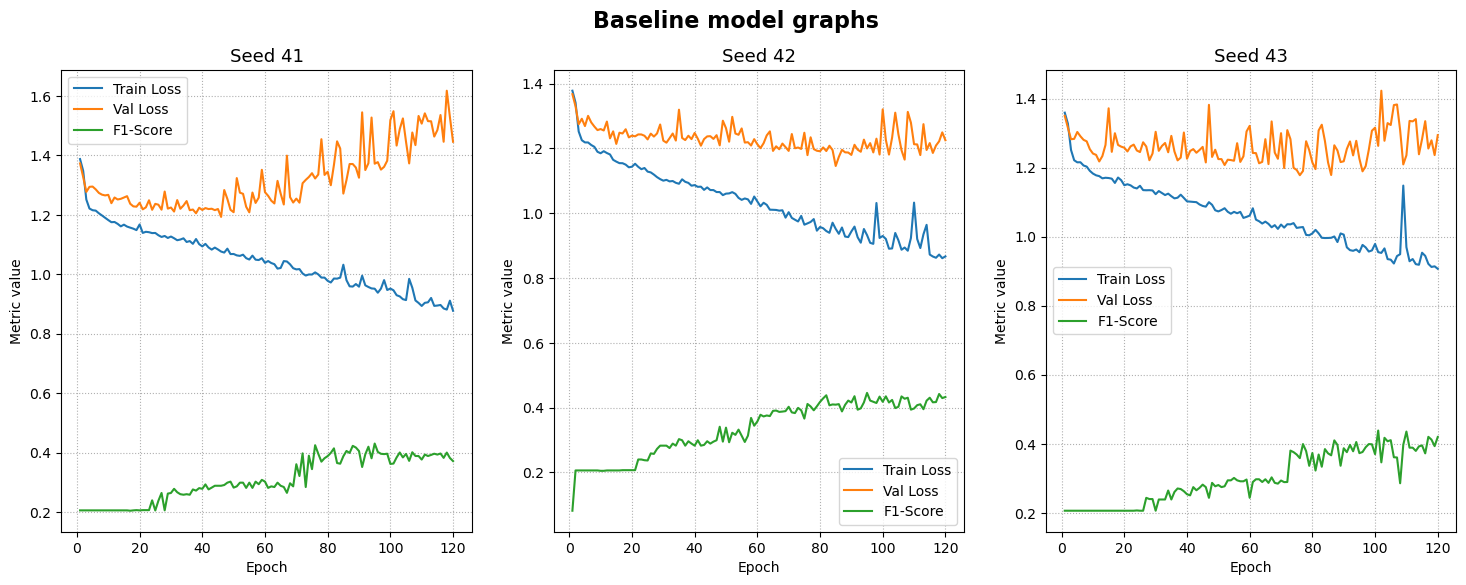

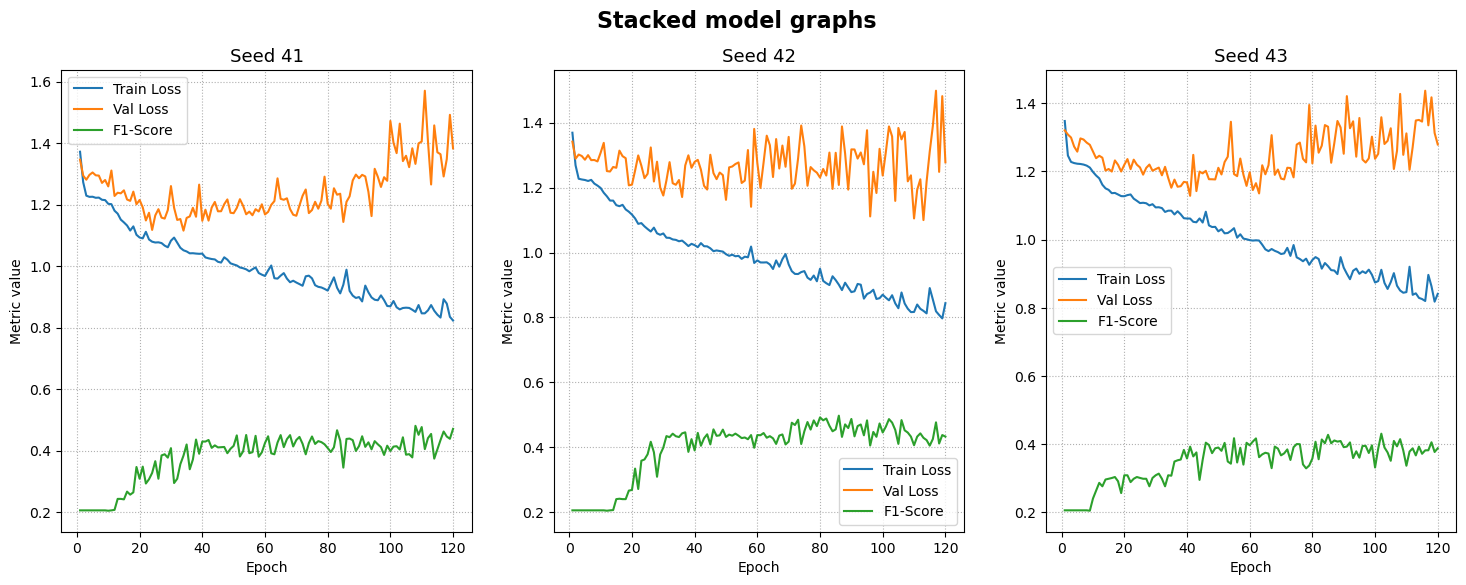

,val_precision,val_recall,val_f1-score,test_precision,test_recall,test_f1-score
41,0.36,0.39,0.37,0.33,0.34,0.33
42,0.41,0.47,0.43,0.30,0.34,0.31
43,0.40,0.44,0.42,0.34,0.38,0.35


,val_precision,val_recall,val_f1-score,test_precision,test_recall,test_f1-score
41,0.53,0.45,0.47,0.44,0.39,0.41
42,0.45,0.44,0.43,0.44,0.43,0.41
43,0.38,0.43,0.39,0.35,0.39,0.35


In [63]:
def plot_model_data(chart_data: pd.DataFrame, epochs: int, title: str, seeds: List):
    """
    It plots the train, val loss and the f1-score for multiple seeds.
    
    :param chart_data: the chart data to plot.
    :param epochs: the number of epochs.
    :param title: the title of the plot.
    :param seeds: the list of the seeds.
    """
    num_seeds = len(chart_data)

    # Setup the figure
    fig, graphs = plt.subplots(1, num_seeds, figsize=(18,2 * num_seeds), sharex=True)
    fig.suptitle(title, fontsize=16, fontweight="bold")

    for i, seed in enumerate(seeds):
        graph = graphs[i]
        
        # Plot metrics
        graph.plot(epochs, chart_data.loc[seed]['train_loss'], label="Train Loss")
        graph.plot(epochs, chart_data.loc[seed]['val_loss'], label="Val Loss")
        graph.plot(epochs, chart_data.loc[seed]['f1-score'], label="F1-Score")

        graph.set_title(f"Seed {seed}", fontsize=13)
        graph.set_xlabel("Epoch")
        graph.set_ylabel("Metric value")
        graph.grid(linestyle=":")
        graph.legend()

    plt.show()

plot_model_data(baseline_chart_data,np.arange(1, cfg["TRAINING_CONFIGURATION_LSTM"]["epochs"]+1),"Baseline model graphs", cfg["seeds"])
plot_model_data(stacked_chart_data,np.arange(1, cfg["TRAINING_CONFIGURATION_LSTM"]["epochs"]+1),"Stacked model graphs", cfg["seeds"])

display(baseline_model_metrics.style.format(precision=2).set_caption("<h3>Baseline model metrics</h3>"))
display(stacked_model_metrics.style.format(precision=2).set_caption("<h3>Stacked model metrics</h3>"))

Looking at the training curves, both the baseline and the stacked LSTM models show a similar trend: the training loss decreases steadily, while the validation loss oscillates more and eventually diverges a bit, which is expected given the strong class imbalance we observed before. Despite this, the F1-score improves across epochs and stabilizes to a score between 0.4 and 0.5 in the validation set, while having bit worse results at test time.

To get a clearer picture of how stable each model is across different seeds, we compute the mean and standard deviation of the validation and test metrics. This lets us compare the baseline and stacked LSTM in a more compact way and see whether one of the two consistently performs better overall.


In [64]:
baseline_summary = pd.DataFrame({
    'mean': baseline_model_metrics.mean(),
    'std': baseline_model_metrics.std()
})

stacked_summary = pd.DataFrame({
    'mean': stacked_model_metrics.mean(),
    'std': stacked_model_metrics.std()
})

val_comparison = pd.DataFrame({
    'precision': [f"{baseline_summary.loc['val_precision','mean']:.2f} ± {baseline_summary.loc['val_precision','std']:.2f}",
                  f"{stacked_summary.loc['val_precision','mean']:.2f} ± {stacked_summary.loc['val_precision','std']:.2f}"],
    'recall': [f"{baseline_summary.loc['val_recall','mean']:.2f} ± {baseline_summary.loc['val_recall','std']:.2f}",
               f"{stacked_summary.loc['val_recall','mean']:.2f} ± {stacked_summary.loc['val_recall','std']:.2f}"],
    'f1-score': [f"{baseline_summary.loc['val_f1-score','mean']:.2f} ± {baseline_summary.loc['val_f1-score','std']:.2f}",
                 f"{stacked_summary.loc['val_f1-score','mean']:.2f} ± {stacked_summary.loc['val_f1-score','std']:.2f}"]
}, index=['Baseline model', 'Stacked model'])

test_comparison = pd.DataFrame({
    'precision': [f"{baseline_summary.loc['test_precision','mean']:.2f} ± {baseline_summary.loc['test_precision','std']:.2f}",
                  f"{stacked_summary.loc['test_precision','mean']:.2f} ± {stacked_summary.loc['test_precision','std']:.2f}"],
    'recall': [f"{baseline_summary.loc['test_recall','mean']:.2f} ± {baseline_summary.loc['test_recall','std']:.2f}",
               f"{stacked_summary.loc['test_recall','mean']:.2f} ± {stacked_summary.loc['test_recall','std']:.2f}"],
    'f1-score': [f"{baseline_summary.loc['test_f1-score','mean']:.2f} ± {baseline_summary.loc['test_f1-score','std']:.2f}",
                 f"{stacked_summary.loc['test_f1-score','mean']:.2f} ± {stacked_summary.loc['test_f1-score','std']:.2f}"]
}, index=['Baseline model', 'Stacked model'])

display(val_comparison.style.set_caption("<h2>Average validation metrics over seeds</h2>"))
display(test_comparison.style.set_caption("<h2>Average test metrics over seeds</h2>"))

,precision,recall,f1-score
Baseline model,0.39 ± 0.03,0.43 ± 0.04,0.41 ± 0.03
Stacked model,0.45 ± 0.08,0.44 ± 0.01,0.43 ± 0.04


,precision,recall,f1-score
Baseline model,0.32 ± 0.02,0.35 ± 0.02,0.33 ± 0.02
Stacked model,0.41 ± 0.05,0.40 ± 0.02,0.39 ± 0.03


The results confirm that the models are reasonably consistent across different seeds, with the stacked version performing a bit better with respect to the baseline in test set, while having approximatively same results in validation.

# Task 6 - Transformers

### Instructions
- **Load the Tokenizer and Model**

- **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

- **Train the Model**:
   Use the `Trainer` to train the model on your training data.

- **Evaluate the Model on the Test Set** using the same metrics used for LSTM-based models.

We preprocess data for transformer model

In [65]:
# we extract relevant columns from the dataframes
train_data_transformer = df_train_en[['tweet_clean','label']].copy()
val_data_transformer = df_val_en[['tweet_clean','label']].copy()
test_data_transformer = df_test_en[['tweet_clean','label']].copy()

# we create the HuggingFace datasets
train_dataset_transformer = Dataset.from_pandas(train_data_transformer)
val_dataset_transformer = Dataset.from_pandas(val_data_transformer)
test_dataset_transformer = Dataset.from_pandas(test_data_transformer)

### Load tokenizer and the transformer model, apply tokenization on the datasets.
We load the tokenizer from the pretrained model *cardiffnlp/twitter-roberta-base-hate*, which is specifically designed for Twitter data. We then tokenize all cleaned tweets using this tokenizer, applying truncation and padding according to the model settings. Finally, we use a data collator to handle dynamic padding during batching.


In [66]:
# load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg["model_card"])

# tokenization function definition
def tokenize_function(examples):
    """
    It tokenizes the input via the specific model tokenizer.
    
    :param examples: the input examples.

    :returns:
        - the tokenized examples
    """
    return tokenizer(
          examples['tweet_clean'],
          truncation=True,
          padding=True,
          max_length=cfg["max_sequence_length"])    

# application of the tokenization to all the datasets
train_dataset_transformer = train_dataset_transformer.map(tokenize_function, batched=True)
val_dataset_transformer = val_dataset_transformer.map(tokenize_function, batched=True)
test_dataset_transformer = test_dataset_transformer.map(tokenize_function, batched=True)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 280/280 [00:00<00:00, 22594.27 examples/s]


We define a custom Trainer subclass, that adjust the loss focusing on class weighting to mitigate the evident class imbalance.

In [67]:
# ----------------CLASS IMBALANCE HANDLING----------------

class TweetTrainer(Trainer):
    """
    Class to customize the Trainer class from transformers library to handle classes imbalance.
    """
    def __init__(self, weight_distribution, device, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weight_distribution = weight_distribution
        self.device = device

    def compute_loss(self,model,inputs,return_outputs=False,**kwargs):
        labels =inputs.get("labels")
        outputs =model(**inputs)
        
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            # we get the logits from the model outputs
            logits = outputs.get('logits')
            # we weight the classes to contrast class imbalance
            criterion = torch.nn.CrossEntropyLoss(weight=self.weight_distribution.to(self.device))
            loss = criterion(logits, labels)
        else:
            # if no labels, default
            loss = outputs.loss if hasattr(outputs, 'loss') else outputs[0]

        return (loss, outputs) if return_outputs else loss

Here we prepare the training arguments for the Hugging Face Trainer. We take the config dictionary, remove the parameters that are handled separately, and build a TrainingArguments object with the settings used for logging, saving checkpoints, evaluation strategy, and reproducibility across seeds.


In [68]:
# ----------------TRAINING CONFIGURATIONS----------------

def get_model_arguments(seed: int, weights_path: Path, logging_steps: int, load_best_model_at_end: bool, greater_is_better: bool, metric_for_best_model: str, dataloader_pin_memory: bool, training_config: dict):
    """
    Returns the training arguments for the Trainer.
    """
    train_config = training_config.copy()
    del train_config['freeze_layers']
    del train_config['from_layer']
    
    return TrainingArguments(
        output_dir=f'{weights_path}/transformer/seed_{seed}',
        eval_strategy='epoch',
        save_strategy='epoch',
        logging_dir=f'./logs_seed{seed}',
        logging_steps=logging_steps,
        load_best_model_at_end=load_best_model_at_end,
        greater_is_better=greater_is_better,
        metric_for_best_model=metric_for_best_model,
        dataloader_pin_memory=dataloader_pin_memory,
        seed=seed,
        **train_config
    )

We define a function that given the model prediction is able to compute the metrics we need for evaluation, it is the standard for huggingface Trainer

In [69]:
def compute_metrics(model_prediction):
    """
    Metric computations for model predictions.
    :param model_prediction: the model predictions.
    :returns:
        - a dictionary containing the: accuracy, f1, precision and recall scores obtained.
    """
    predictions, labels = model_prediction
    predictions = np.argmax(predictions, axis=-1)
    
    precision,recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )
    accuracy = accuracy_score(labels,predictions)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Here we define some utilities for the transformer setup: clearing memory, loading the pretrained model with optional freezing, and plotting the training/evaluation metrics for each seed.


In [70]:
# ----------------UTILS FUNCTIONS----------------

def clear_memory():
    """
    Function to clear the GPU/MPS memory cache.
    """
    with torch.no_grad():
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        elif torch.mps.is_available():
            torch.mps.empty_cache()
    gc.collect()

def load_pretrained_model(model_card: str, 
                          num_labels: int, 
                          training_config: dict,
                          device: torch.device, 
                          ):
    """
    Function to load a pre-trained model for sequence classification.
    """
    model = AutoModelForSequenceClassification.from_pretrained(
        model_card,
        num_labels=num_labels,
        ignore_mismatched_sizes=True
    )

    freeze_layers = training_config["freeze_layers"]
    from_layer = training_config["from_layer"]

    if freeze_layers:
        for name, param in model.named_parameters():
            if 'classifier' in name or any(f'encoder.layer.{i}' in name for i in range(from_layer, 12)):
                param.requires_grad = True
            else:
                param.requires_grad = False

    model.to(device)
    return model

def plot_transformer_metrics(trainers, title="Transformer Training Metrics"):
    """
    Function to plot training and eval metrics.
    """
    num_seeds =len(trainers)
    seeds_list =list(trainers.keys())
    
    fig,axes=plt.subplots(1,num_seeds,figsize=(6*num_seeds,5))
    
    if num_seeds == 1:
        axes=[axes]
    
    fig.suptitle(title,fontsize=16,fontweight="bold")
    
    for idx, seed in enumerate(seeds_list):
        ax =axes[idx]
        trainer =trainers[seed]
        log_history =trainer.state.log_history
        
        # useful metrics
        epochs =[]
        train_losses =[]
        val_losses =[]
        val_f1s =[]
        
        for entry in log_history:
            
            if 'eval_loss' in entry and 'eval_f1' in entry:
                epoch = entry['epoch']
                if epoch not in epochs:
                    epochs.append(epoch)
                    val_losses.append(entry['eval_loss'])
                    val_f1s.append(entry['eval_f1'])
        
        # we calculate the avergae training loss per epoch
        train_loss_epoch = {}

        for entry in log_history:
            if 'loss' in entry and 'eval_loss' not in entry:
                epoch_float = entry['epoch']
                epoch_int = int(np.ceil(epoch_float))
                if epoch_int not in train_loss_epoch:
                    train_loss_epoch[epoch_int]=[]
                train_loss_epoch[epoch_int].append(entry['loss'])
        
        train_epochs = sorted(train_loss_epoch.keys())
        train_losses = [np.mean(train_loss_epoch[e]) for e in train_epochs]
        
        # we plot the metrics
        ax.plot(train_epochs, train_losses, label='Train Loss')
        ax.plot(epochs, val_losses, label='Val Loss')
        ax.plot(epochs, val_f1s, label='F1-Score')
        
        ax.set_title(f"Seed {seed}", fontsize=13)
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Metric Value")
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    plt.tight_layout()
    plt.show()

### Transformer training

This function trains the transformer model across multiple seeds to check the stability of the results. For each seed we set the random state, load the pretrained model with the chosen configuration, create a custom Trainer with our weighted loss and early stopping, run the training, and save the best model according to f1_score. We also clean up intermediate checkpoints to reduce disk usage and store both the results and trainer objects for later analysis.


In [71]:
def train_transformer_multiple_seeds(
        model_card,
        train_dataset: Dataset,
        val_dataset: Dataset,
        tokenizer,
        data_collator,
        device,
        weights_path: Path,
        logging_steps: int,
        load_best_model_at_end: bool,
        greater_is_better: bool,
        metric_for_best_model: str,
        dataloader_pin_memory: bool,
        training_config:dict,
        seeds: List[int],
        num_labels: int = 4,
):
    results = {}
    trainers = {}

    print(f"Using device: {cfg['device']}")

    for seed in seeds:
        print(f"Training with seed: {seed}")

        # setting the seeds for reproducibility
        set_seed(seed)
        training_args = get_model_arguments(seed, weights_path, logging_steps, load_best_model_at_end, greater_is_better, metric_for_best_model, dataloader_pin_memory, training_config)

        # we clear the memory cache
        clear_memory()

        # we load the pre-trained model
        model = load_pretrained_model(model_card, num_labels, training_config, cfg["device"])

        # we save the BEST model path
        transformer_weights_path = cfg["weights_path"]/ "transformer"
        os.makedirs(transformer_weights_path,exist_ok=True)
        save_path = transformer_weights_path / f"transformer_seed_{seed}.pth"
        
        # create the custom trainer class
        trainer = TweetTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            processing_class=tokenizer,
            weight_distribution=get_weights_distribution(df_train_en,"sqrt_inverse"),
            data_collator=data_collator,
            device=device,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )

        # train the model
        train_result = trainer.train()

        torch.save(trainer.model.state_dict(), save_path)
        print(f"The best transformer model saved to {save_path}")

        # we clean temporary files with checkpoints created during training to save disk space
        output_dir = training_args.output_dir
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
            
        results[seed] = {
            'train_result': train_result,
        }
        
        trainers[seed] = trainer

    return results, trainers

This function evaluates each transformer model trained with a different seed. For every seed we run the evaluation on both the validation and test sets, extract the main metrics, and collect them in a single DataFrame so we can easily compare the performance across seeds.


In [72]:
def evaluate_transformer_multiple_seeds(
        trainers:Dict,
        val_dataset:Dataset,
        test_dataset:Dataset,
        seeds:List[int]
):
    results= pd.DataFrame(
        columns=['val_precision','val_recall','val_f1-score','test_precision','test_recall','test_f1-score'], 
        index=seeds
    )
    
    for seed in seeds:
        trainer = trainers[seed]

        val_metrics = trainer.evaluate(eval_dataset=val_dataset)
        test_metrics =trainer.evaluate(eval_dataset=test_dataset)
        results.loc[seed]={
            'val_precision': round(val_metrics['eval_precision'],2),
            'val_recall':round(val_metrics['eval_recall'], 2),
            'val_f1-score': round(val_metrics['eval_f1'],2),
            'test_precision':round(test_metrics['eval_precision'], 2),
            'test_recall': round(test_metrics['eval_recall'], 2),
            'test_f1-score': round(test_metrics['eval_f1'], 2),
        }

    return results
    

In [73]:
results,trainers = train_transformer_multiple_seeds(
    model_card=cfg["model_card"],
    train_dataset=train_dataset_transformer,
    val_dataset=val_dataset_transformer,
    tokenizer=tokenizer,
    data_collator=data_collator,
    device=cfg["device"],
    weights_path=cfg["weights_path"],
    logging_steps=cfg["logging_steps"],
    load_best_model_at_end=cfg["load_best_model_at_end"],
    greater_is_better=cfg["greater_is_better"],
    metric_for_best_model=cfg["metric_for_best_model"],
    dataloader_pin_memory=cfg["dataloader_pin_memory"],
    training_config=cfg["TRAINING_CONFIGURATIONS_TRANSFORMER"],
    seeds=cfg["seeds"],
    num_labels=cfg["num_labels"]
)

Using device: cuda
Training with seed: 41


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.913500,0.907981,0.740000,0.525329,0.534278,0.557531
2,0.900400,0.915179,0.780000,0.537375,0.523342,0.569125
3,0.576300,0.893910,0.760000,0.485627,0.471200,0.520911
4,0.583900,0.893186,0.813333,0.618792,0.648350,0.600699
5,0.633600,0.866393,0.780000,0.578016,0.585940,0.581625


The best transformer model saved to weights\transformer\transformer_seed_41.pth
Training with seed: 42


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.946500,0.920176,0.726667,0.427734,0.405385,0.472101
2,0.597500,0.880063,0.773333,0.495029,0.467033,0.542650
3,0.612800,0.858415,0.800000,0.621708,0.632178,0.628520
4,0.618400,0.881925,0.786667,0.587179,0.601282,0.592650
5,0.557600,0.867793,0.793333,0.586082,0.588640,0.585067


The best transformer model saved to weights\transformer\transformer_seed_42.pth
Training with seed: 43


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.704000,0.903971,0.733333,0.440974,0.422733,0.492935
2,0.778100,0.876330,0.780000,0.591222,0.579509,0.615735
3,0.731700,0.893292,0.806667,0.555988,0.524109,0.598473
4,0.562600,0.861102,0.806667,0.598641,0.592376,0.608282
5,0.846000,0.860448,0.806667,0.598641,0.592376,0.608282


The best transformer model saved to weights\transformer\transformer_seed_43.pth


### Transformer evaluation on val. and test. datasets

In [74]:
results = evaluate_transformer_multiple_seeds(
    trainers=trainers,
    val_dataset=val_dataset_transformer,
    test_dataset=test_dataset_transformer,
    seeds=cfg["seeds"]
)

# Display results
display(results.style.format(precision=2).set_caption("<h3>Transformer Results</h3>"))

,val_precision,val_recall,val_f1-score,test_precision,test_recall,test_f1-score
41,0.65,0.60,0.62,0.54,0.54,0.53
42,0.63,0.63,0.62,0.54,0.55,0.54
43,0.59,0.61,0.60,0.49,0.51,0.49


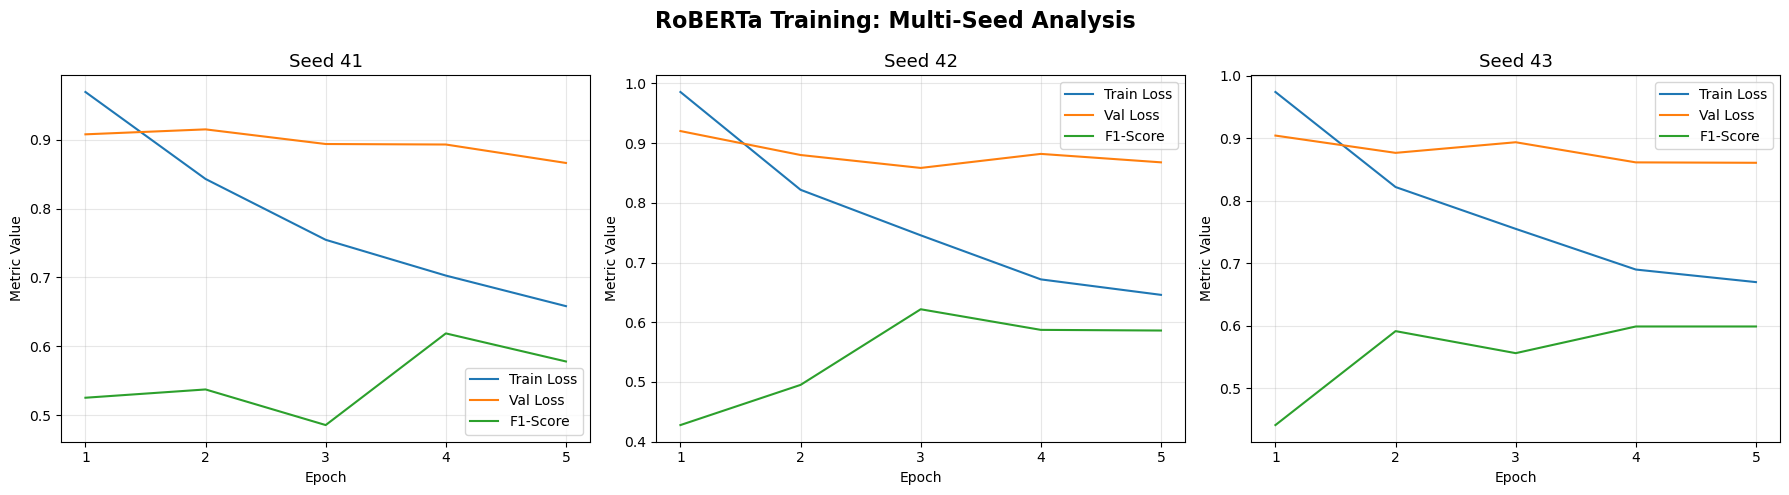

In [75]:
# ----------------RESULTS VISUALIZATION----------------
plot_transformer_metrics(trainers, title="RoBERTa Training: Multi-Seed Analysis")

The multi-seed plots show a very consistent behaviour across runs. The training loss decreases smoothly for all seeds, while the validation loss stays relatively stable with only small fluctuations. The F1-score improves over the epochs and stays around the same level for every seed, confirming that the model is not overly sensitive to the random initialization. Compared to the LSTM, the transformer reaches much higher scores with far less training, and the results remain stable despite the class imbalance.


In [76]:
# compute mean and std over the seeds
transformers = pd.DataFrame({
    'mean': results.mean(),
    'std': results.std()
})
val_comparison_transformer = pd.DataFrame({
    'precision': [f"{transformers.loc['val_precision','mean']:.2f} ± {transformers.loc['val_precision','std']:.2f}"],
    'recall':[f"{transformers.loc['val_recall','mean']:.2f} ± {transformers.loc['val_recall','std']:.2f}"],
    'f1-score':[f"{transformers.loc['val_f1-score','mean']:.2f} ± {transformers.loc['val_f1-score','std']:.2f}"]
}, index=['Transformer model'])

test_comparison_transformer = pd.DataFrame({
    'precision': [f"{transformers.loc['test_precision','mean']:.2f} ± {transformers.loc['test_precision','std']:.2f}"],
    'recall':[f"{transformers.loc['test_recall','mean']:.2f} ± {transformers.loc['test_recall','std']:.2f}"],
    'f1-score':[f"{transformers.loc['test_f1-score','mean']:.2f} ± {transformers.loc['test_f1-score','std']:.2f}"]
}, index=['Transformer model'])

display(val_comparison_transformer.style.set_caption("<h3>Average validation set results over the seeds</h3>"))
display(test_comparison_transformer.style.set_caption("<h3>Average test set results over the seeds</h3>"))

,precision,recall,f1-score
Transformer model,0.62 ± 0.03,0.61 ± 0.02,0.61 ± 0.01


,precision,recall,f1-score
Transformer model,0.52 ± 0.03,0.53 ± 0.02,0.52 ± 0.03


The mean and standard deviation across different seeds confirm that the model is robust to initial randomness and behaves consistently across runs. On top of that, the pretrained transformer reaches significantly better performance than the LSTM models, both in terms of overall F1-score and stability.


# [Task 7 - 0.5 points] Error Analysis

After evaluating the model, perform a brief error analysis:

### Instructions

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.

First, we define helper functions to load weights from local checkpoints. The loaded models are then stored in a dictionary that maps model names to their instantiated model.

In [77]:
models={
    "baseline": lambda: LSTM_model(emb_dimension=cfg["embedding_dimension"],
                                   emb_weights=emb_weights,
                                   seq_length=cfg["max_sequence_length"],
                                   n_layers=cfg["TRAINING_CONFIGURATION_LSTM"]["baseline_layers"],
                                   num_labels=cfg["num_labels"],
                                   training_config=cfg["TRAINING_CONFIGURATION_LSTM"]),
    "stacked": lambda: LSTM_model(emb_dimension=cfg["embedding_dimension"],
                                   emb_weights=emb_weights,
                                   seq_length=cfg["max_sequence_length"],
                                   n_layers=cfg["TRAINING_CONFIGURATION_LSTM"]["stacked_layers"],
                                   num_labels=cfg["num_labels"],
                                   training_config=cfg["TRAINING_CONFIGURATION_LSTM"]),
    "transformer": lambda: AutoModelForSequenceClassification.from_pretrained(cfg["model_card"],num_labels=cfg["num_labels"],ignore_mismatched_sizes=True)
}

Load weights of a single model

In [78]:
def load_weights(model, checkpoint_path: Path, device: str):
    ''' 
    Function to load model weights from a checkpoint file.

    :param model: the model to load the weights into.
    :param checkpoint_path: the path to the checkpoint file.
    :param device: the device to map the model to.

    :returns:
        - the model with loaded weights
    '''
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"File di pesi non trovato: {checkpoint_path}")

    print(f"Loading model from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint)

    model.to(device)
    model.eval()

    return model


Uncomment this line to download the weights of the models from Google Drive

In [ ]:
#download_all_files_gdown(cfg["weights_path"],cfg["weights_URL"])

Load the weights of all models

In [80]:
def load_all_models(models: Dict, weights_dir: Path, device: str):
    ''' 
    Function to load all models (baseline, stacked and transformer) from their respective checkpoint files.

    :param models: dictionary mapping model types to their factory functions.
    :param weights_dir: the directory containing the model weights.
    :param device: the device to map the models to.

    :returns:
        - dictionary mapping model names to loaded model instances
    '''
    loaded = {}
    for model_type, model in models.items():
        weights_path = os.path.join(weights_dir, model_type)
        
        for filename in os.listdir(weights_path):

            seed = filename.split('_')[-1]
            checkpoint_path = os.path.join(weights_path, filename)

            loaded_model = load_weights(model(), checkpoint_path, device)

            model_name = f"{model_type}_seed_{seed}"
            model_name = model_name.removesuffix(".pth")
            loaded[model_name] = loaded_model

    return loaded

loaded_models = load_all_models(models, cfg["weights_path"], cfg["device"])

Loading model from: weights\baseline\baseline_seed_41.pth
Loading model from: weights\baseline\baseline_seed_42.pth
Loading model from: weights\baseline\baseline_seed_43.pth
Loading model from: weights\stacked\stacked_seed_41.pth
Loading model from: weights\stacked\stacked_seed_42.pth
Loading model from: weights\stacked\stacked_seed_43.pth


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from: weights\transformer\transformer_seed_41.pth


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from: weights\transformer\transformer_seed_42.pth


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model from: weights\transformer\transformer_seed_43.pth


After loading all the models, we generate predictions on the test set and store, for each model, the logits, the predicted labels, and the true labels.

In [81]:
def make_predictions(model, data: DataLoader, device: str, is_transformer: bool=False):
    ''' 
    Function to make predictions with a given model (either a transformer or a standard PyTorch model) 
    on a specified dataset. Collects logits, predicted classes, and true labels.

    :param model: the model to use for predictions.
    :param data: the DataLoader containing the dataset.
    :param device: the device to map the data and model to.
    :param is_transformer: flag indicating if the model is a transformer.

    :returns:
        - logits: the raw output scores from the model
        - predictions: the predicted class labels
        - true_labels: the actual class labels
    '''
    logits = []
    predictions = []
    true_labels = []

    with torch.no_grad(): 
        for batch in tqdm(data):
            if is_transformer:
                input_ids = torch.tensor(batch["input_ids"]).unsqueeze(0).to(device)
                attention_mask = torch.tensor(batch["attention_mask"]).unsqueeze(0).to(device)
                labels = torch.tensor(batch["label"]).unsqueeze(0).to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                scores = outputs.logits
            else:
                x,labels = batch
                x = x.to(device)
                labels = labels.to(device)
                scores = model(x)

            logits.append(scores)
            true_labels.append(labels)

    logits = torch.cat(logits, dim=0).cpu().numpy()
    true_labels = torch.cat(true_labels, dim=0).cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    return logits, predictions, true_labels


In [82]:
data = {
    "baseline": test_loader_lstm,
    "stacked": test_loader_lstm,
    "transformer": test_dataset_transformer
}

def predict_all_models(models: Dict, data: Dict, device: str):
    '''
    Function to collect predictions from all models contained in the models dictionary on their 
    respective datasets.

    :param models: dictionary mapping model names to model instances.
    :param data: dictionary mapping model types to their respective datasets.
    :param device: the device to map the data and models to.

    :returns:
        - dictionary mapping model names to their prediction logits, predicted classes, and true labels
    '''
    results = {}
    for model_name, model in models.items():
        is_transformer = model_name.startswith("transformer")
        model_type = model_name.split('_')[0] 
        logits, predictions, true_labels = make_predictions(
            model=model,
            data=data[model_type],
            device=device,
            is_transformer=is_transformer
        )

        results[model_name] = {
            'logits': logits,
            'predictions': predictions,
            'true_labels': true_labels
        }

    return results

all_model_predictions = predict_all_models(loaded_models, data, cfg["device"])

100%|██████████| 280/280 [00:02<00:00, 122.98it/s]


We perform error analysis on the ensemble of the three models of each type. We provide two different ways of ensembling models:
- majority vote: the final predicted class is the one selected by most models; the confidence is computed as the proportion of votes each class receives.
- higher confidence: the final prediction corresponds to the class with the highest average confidence, obtained by averaging the logits across the three seeds.

For the error analysis we choose the higher confidence method

In [83]:
def ensemble_model(models_preds: Dict, 
                    model_type: Literal['transformer', 'stacked', 'baseline'], 
                    method: Literal['majority_vote', 'higher_confidence']):
    
    ''' 
    Function to perform ensemble predictions using either majority voting or higher confidence methods. 
    It aggregates predictions from multiple models of the same type. 

    :param models_preds: dictionary mapping model names to their predicted logits, predicted classes, and true labels.
    :param model_type: the type of models to ensemble ('transformer', 'stacked', or 'baseline').
    :param method: the ensemble method to use ('majority_vote' or 'higher_confidence').

    :returns confidences: the confidence scores for each prediction
    :returns preds: the final predicted class labels after ensembling
    :returns true_labels: the actual class labels
    '''

    names = [model_name for model_name in models_preds.keys() if model_name.startswith(model_type)] 
    true_labels = models_preds[names[0]]['true_labels']
    
    if method=='majority_vote':
        predictions = [models_preds[name]['predictions'] for name in names]
        preds_stack = np.stack(predictions)
        
        maj_vote = []
        confidences = []
        for i in range(preds_stack.shape[1]):
            raters = preds_stack[:, i]
            winner = int(mode(raters, axis=0).mode)
            maj_vote.append(winner)

            conf = np.array([np.mean(raters == c) for c in range(cfg['num_labels'])])
            confidences.append(conf)

        preds = np.array(maj_vote)
        confidences = np.array(confidences)

    elif method=='higher_confidence':
        logits = [models_preds[name]['logits'] for name in names]
        conf_stack = np.stack(logits)
        mean = np.mean(conf_stack, axis=0)
        confidences = softmax(mean, axis=1)
        preds = np.argmax(mean, axis=1)

    return confidences, preds, true_labels

In [84]:
baseline_ens_conf, baseline_ens_preds, true_labels_baseline = ensemble_model(all_model_predictions, 'baseline', cfg["ensemble_method"])
stacked_ens_conf, stacked_ens_preds, true_labels_stacked = ensemble_model(all_model_predictions, 'stacked', cfg["ensemble_method"])
transformer_ens_conf, transformer_ens_preds, true_labels_transformer = ensemble_model(all_model_predictions, 'transformer', cfg["ensemble_method"])

# Storing all model results in a dictionary mapping ensemble types to their predictions, true labels, and confidence scores
model_results = {
    "baseline": {
        "preds": baseline_ens_preds,
        "true_labels": true_labels_baseline,
        "conf": baseline_ens_conf
    },
    "stacked": {
        "preds": stacked_ens_preds,
        "true_labels": true_labels_stacked,
        "conf": stacked_ens_conf
    },
    "transformer": {
        "preds": transformer_ens_preds,
        "true_labels": true_labels_transformer,
        "conf": transformer_ens_conf
    }
}

Visualization of the classification report

In [85]:
def plot_classification_report(y_pred:np.ndarray,y_true:np.ndarray,model_name:str,ax):
    """
    Function to plot classification report as heatmap.
    """
    cr=classification_report(y_true,y_pred,output_dict=True,zero_division=0)
    cr=pd.DataFrame(cr).T

    cr.index = list(mapping.keys()) + ["accuracy", "macro avg", "weighted avg"] 
    
    sns.heatmap(
        cr.iloc[:,:].astype(float), 
        annot=True, 
        fmt=".2f",
        cmap="Greens", 
        cbar=False,
        xticklabels=cr.columns, 
        yticklabels=cr.index,
        linewidths=0.6,
        linecolor="black",
        ax=ax
    )
    
    ax.set_facecolor("white")
    ax.set_title(f'CR {model_name}',fontsize=14,weight="bold")
    ax.tick_params(axis='x',labelsize=10)
    ax.tick_params(axis='y',labelsize=10)


def plot_confusion_matrix(y_pred:np.ndarray,y_true:np.ndarray,model_name:str,ax):
    """
    Function to plot the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Greens",colorbar=False,ax=ax)
    
    ax.set_facecolor("white")
    ax.set_title(f'CM {model_name}',fontsize=14,weight="bold")
    ax.set_xlabel("Predicted Labels",fontsize=12)
    ax.set_ylabel("True Labels",fontsize=12)
    ax.tick_params(axis='x',labelsize=10)
    ax.tick_params(axis='y',labelsize=10)

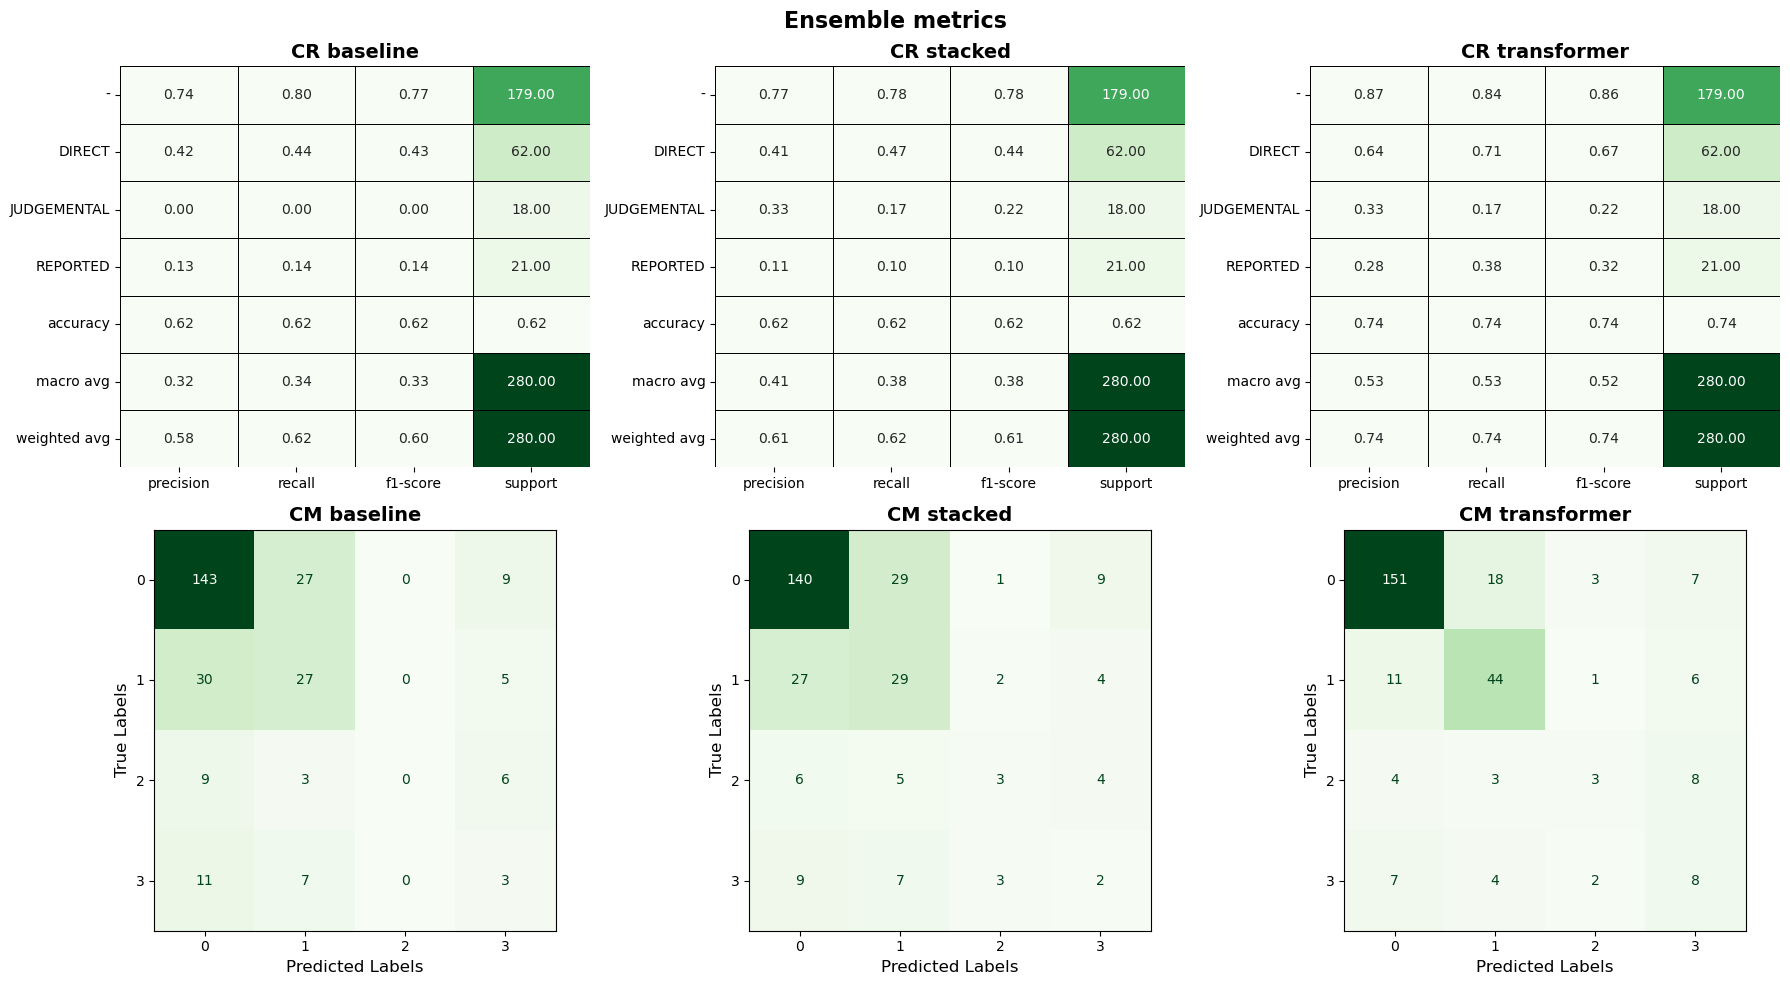

In [86]:
# plotting classifiation report and confusion matrix for each seed
fig,axes = plt.subplots(2, len(cfg['seeds']),figsize=(6*len(cfg['seeds']),10))
fig.suptitle("Ensemble metrics", fontsize=16, fontweight="bold")

for idx, model_name in enumerate(model_results.keys()):
    preds, true_labels = model_results[model_name]["preds"], model_results[model_name]["true_labels"]

    plot_classification_report(preds, true_labels, model_name, axes[0, idx])
    plot_confusion_matrix(preds, true_labels, model_name, axes[1, idx])
plt.tight_layout()
plt.show()

The main limitation observed in all models lies in handling the minority classes, particularly Class 2 (which is never predicted by the basline ensemble). The shift from single-layer Bi-LSTM to a two-layer Bi-LSTM provides a slight performance boost since the stacked model is able to better predict the minority classes. Switching to Transformer, instead, leads to significant improvemnts over the other two models. The transformer achieves better precision and recall on all the four classes, espcially in the minority ones.

To further inspect how the models handle the different classes we also plot Precision/Recall curves

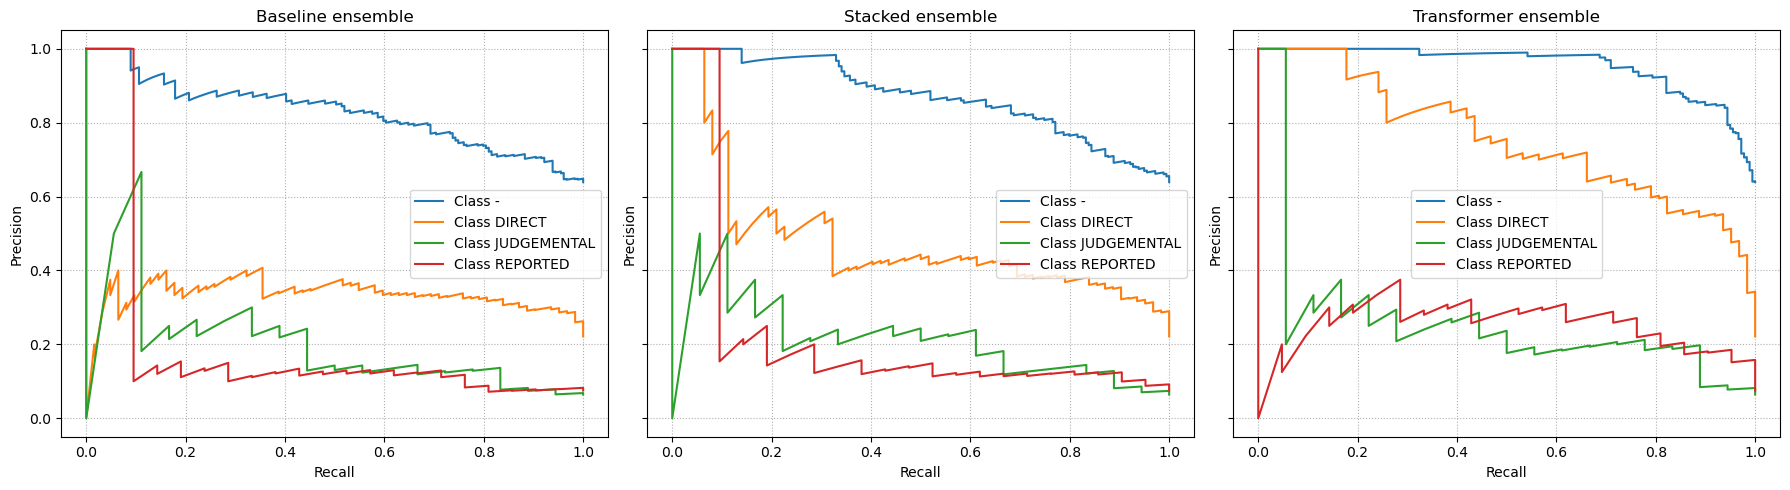

In [87]:
def compute_precision_recall_curve(labels: np.array, predictions: np.array, num_classes: int, ax: plt.axes, title: str = ''):

    for class_idx in range(num_classes):
        true_labels_binary = (labels == class_idx).astype(int)
        class_scores = predictions[:, class_idx]
        precision, recall, _ = precision_recall_curve(true_labels_binary, class_scores)
 
        ax.plot(recall, precision, label=f"Class {list(mapping.keys())[class_idx]}")  
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(title)
    ax.grid(linestyle=':')
    ax.legend()


fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
compute_precision_recall_curve(true_labels_baseline, baseline_ens_conf, cfg["num_labels"], axes[0], "Baseline ensemble")
compute_precision_recall_curve(true_labels_stacked, stacked_ens_conf, cfg["num_labels"], axes[1], "Stacked ensemble")
compute_precision_recall_curve(true_labels_transformer, transformer_ens_conf, cfg["num_labels"], axes[2], 'Transformer ensemble')

plt.tight_layout()
plt.show()

Precision/recall curves reflect what already seen from the classification report. All the models obtain decent performances on class 0 but struggle with other classes. The transformer shows a significant improvement with respect to the other models, especially on class 1 and class 3 . It has comparable results on class 2 instead.

Now we define a function that, given the predictions and their associated confidence scores, retrieves from the dataset the tweets that were misclassified with the highest confidence. This will allow us to inspect the examples for which the model is confidently wrong. We also define a helper function to format and display the selected misclassified examples.

In [88]:
def get_errors(dataset, predictions: np.array, confidences: np.array, true_labels: np.array):
    '''
    Function to get the misclassified samples along with their confidence scores sorted by confidence.

    :param dataset: the dataset containing the samples.
    :param predictions: the predicted class labels.
    :param confidences: the confidence scores for the predictions.
    :param true_labels: the true class labels.
    '''

    wrong_indices = np.where(predictions != true_labels)[0]
    wrong_conf = np.max(confidences[wrong_indices], axis=1)
    sorted_errors = sorted(zip(wrong_indices, wrong_conf), key=lambda x: x[1], reverse=True)

    results = []
    for idx, conf in sorted_errors:
        if hasattr(dataset,'tensors'):  # TensorDataset
            text = df_test_en.iloc[idx]['tweet']
        else:
            text = dataset[int(idx)]['tweet_clean']
        results.append({
            "index": int(idx),
            "text": text,
            "true_label": true_labels[idx],
            "pred_label": predictions[idx],
            "confidence": conf
        })
    
    return results

def print_K_sentences(all_errors, df_test, label, k: int):
    for i in range(k):
        print("-----")
        print(f"ORIGINAL SENTENCE: {df_test.iloc[all_errors[i]['index']]['tweet']}")
        print(f"INPUT {label} SENTENCE: {all_errors[i]['text']}")
        print(f"True class: {list(mapping.keys())[all_errors[i]['true_label']]}, Predicted class: {list(mapping.keys())[all_errors[i]['pred_label']]}, Confidence: {all_errors[i]['confidence']:.4f}")
        print("-----\n\n")


We now perform common error. First, we collect all misclassified examples for each ensemble and extract their corresponding indices. By intersecting these sets, we obtain the subset of tweets that are misclassified by all three model types.

In [89]:
# common errors 
k = len(test_dataset_lstm)
all_errors_baseline = get_errors(test_dataset_lstm, baseline_ens_preds, baseline_ens_conf, true_labels_baseline)
all_errors_stacked = get_errors(test_dataset_lstm, stacked_ens_preds, stacked_ens_conf, true_labels_stacked)
all_errors_transformer = get_errors(test_dataset_transformer, transformer_ens_preds, transformer_ens_conf, true_labels_transformer)

all_wrong_indices_baseline = [error['index'] for error in all_errors_baseline]
all_wrong_indices_stacked = [error['index'] for error in all_errors_stacked]
all_wrong_indices_transformer = [error['index'] for error in all_errors_transformer]

# common wrong predictions
common_wrong = set(all_wrong_indices_baseline) & set(all_wrong_indices_stacked) & set(all_wrong_indices_transformer)
print(f"Number of common wrong predictions: {len(common_wrong)} \n")

comparison_dataframe=[]
for idx in list(common_wrong)[:10]:
    text_transformer = test_dataset_transformer[int(idx)]['tweet_clean']
    text_lstm = df_test_en.iloc[idx]['tweet']
    true_label = true_labels_baseline[idx]
    baseline_pred = baseline_ens_preds[idx]
    stacked_pred = stacked_ens_preds[idx]
    transformer_pred = transformer_ens_preds[idx]
    
    print("-----")
    print(f"ORIGINAL SENTENCE: {df_test.iloc[idx]['tweet']}")
    print(f"PROCESSED SENTENCE INPUT LSTM: {text_lstm}")
    print(f"PROCESSED SENTENCE INPUT TRANSFORMER: {text_transformer}")
    print(f"True class: {list(mapping.keys())[(true_label)]}, Baseline pred: {list(mapping.keys())[baseline_pred]}, Stacked pred: {list(mapping.keys())[stacked_pred]}, Transformer pred: {list(mapping.keys())[transformer_pred]}") 
    print("-----\n\n")

Number of common wrong predictions: 50 

-----
ORIGINAL SENTENCE: @pelecius @iammrstiles @ZykieMan @jihadwatchRS didn't abuse him saying it to his face.Proofs to prove this is a false writing_ The prophet detest hurting of women generally to the extent he warned his companions that women shouldn't be hurt during wars talkless of being killed.-The prophet is against killing of any unless
PROCESSED SENTENCE INPUT LSTM: didnt abuse him say it to his <UNK> to prove this be a false write the <UNK> <UNK> hurting of woman generally to the extent he warn his companion that woman shouldnt be hurt during war <UNK> of be <UNK> <UNK> be against kill of any unless <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
PROCESSED SENTENCE INPUT TRANSFORMER: didnt abuse him saying it to his faceproofs to prove this is a false writing the prophet detest hurting of women generally to the extent he warned his companions that women shouldnt be hurt during wars talkless of being killedthe prophet is against killi

As we can see from the examples above many of the errors derive from the lack of complete context. In particular, several tweets reference to external resources or other users, which were removed during preprocessing, potentially leading to misclassifications. The removal of quotation marks can also be misleading, for example the tweet --- "get changed , you look like a prostitute ." She smirked [...] --- quotes play a key role for the correct interpretation of the sentence. Another possible source of error is sarcasm, which is not correctly detected by the models. Finally, some sentences are intrinsically difficoult to classify, even for a humans, sas reflected by the variability in annotations provided by different annotators.

We then visualize a selection of the highest-confidence misclassifications for each model separately

In [90]:
print_K_sentences(all_errors_baseline, df_test, "LSTM BASELINE", k=5)


-----
ORIGINAL SENTENCE: @BBCYaldaHakim Kabul: Islamic Emirate of Afghanistan has announced the end of co-education in the country, citing "gender harassment".Female students will attend universities on Monday, Wednesday, and Saturday while Tuesday, Thursday, and Sunday are fixed for males.
INPUT LSTM BASELINE SENTENCE: <UNK> islamic <UNK> of afghanistan have announce the end of <UNK> in the country cite gender <UNK> student will attend university on <UNK> wednesday and saturday while tuesday thursday and sunday be fix for male <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
True class: REPORTED, Predicted class: -, Confidence: 0.9242
-----


-----
ORIGINAL SENTENCE: According to the Human Rights Commission, 1 in 3 people experience sexual harassment at work. We have created an online course  providing strategies to prevent and respond should incidents occur. Start your course at: https://t.co/yC40T3cJao #guardianp

In [91]:
print_K_sentences(all_errors_stacked, df_test, "LSTM STACKED", k=5)


-----
ORIGINAL SENTENCE: @BBCYaldaHakim Kabul: Islamic Emirate of Afghanistan has announced the end of co-education in the country, citing "gender harassment".Female students will attend universities on Monday, Wednesday, and Saturday while Tuesday, Thursday, and Sunday are fixed for males.
INPUT LSTM STACKED SENTENCE: <UNK> islamic <UNK> of afghanistan have announce the end of <UNK> in the country cite gender <UNK> student will attend university on <UNK> wednesday and saturday while tuesday thursday and sunday be fix for male <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
True class: REPORTED, Predicted class: -, Confidence: 0.9650
-----


-----
ORIGINAL SENTENCE: According to the Human Rights Commission, 1 in 3 people experience sexual harassment at work. We have created an online course  providing strategies to prevent and respond should incidents occur. Start your course at: https://t.co/yC40T3cJao #guardianps

In [92]:
print_K_sentences(all_errors_transformer, df_test, "TRANSFORMER", k=5)

-----
ORIGINAL SENTENCE: @Mistywoman1 Have I missed something, or has phallocentrism become the latest cult?
INPUT TRANSFORMER SENTENCE: have i missed something or has phallocentrism become the latest cult
True class: JUDGEMENTAL, Predicted class: -, Confidence: 0.9586
-----


-----
ORIGINAL SENTENCE: Fuck's sake is it possible to have a furry space that's not explicitly content-restricted and doesn't immediately become yet another showcase for size-queen phallocentrism?
INPUT TRANSFORMER SENTENCE: fucks sake is it possible to have a furry space thats not explicitly contentrestricted and doesnt immediately become yet another showcase for sizequeen phallocentrism
True class: JUDGEMENTAL, Predicted class: -, Confidence: 0.9103
-----


-----
ORIGINAL SENTENCE: I’m just a pretty little freaky black slut who wants to be filled up with cum and treated like a princess 🥰 Look at the view 🥵  scenes from my first scat video :) #nsfwtwt #blonde #babygirl #creamyebony #creamypussy #daddysgirl #hor

We perform an additional analysis to investigate whether the presence of `<UNK>` tokens affects model performance. To do so, we compute the number of `<UNK>` tokens and the effective tweet length (excluding `<PAD>`), and visualize their relationship using a scatter plot. Points are colored based on whether the model correctly classified the tweet, allowing us to assess whether unknown tokens correlate with misclassification. This analysis is performed only for the LSTM models because the transformer model does not rely on the dictionry we created.

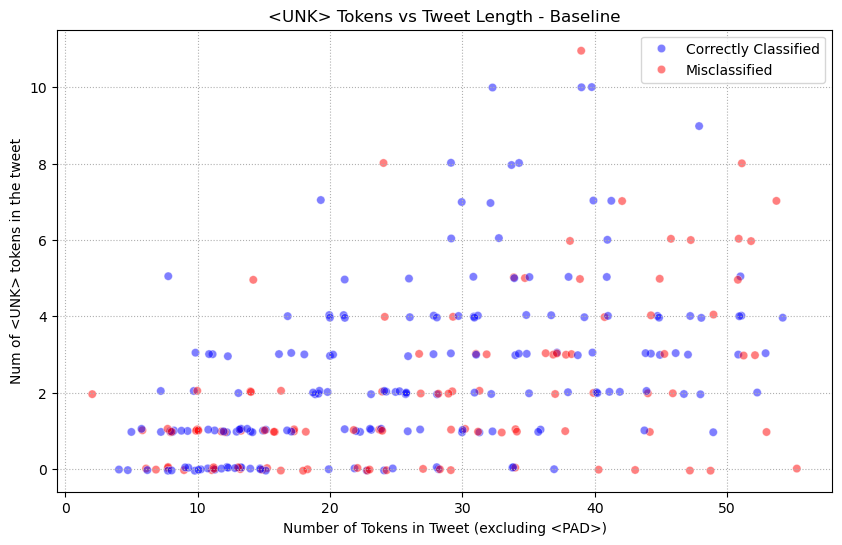

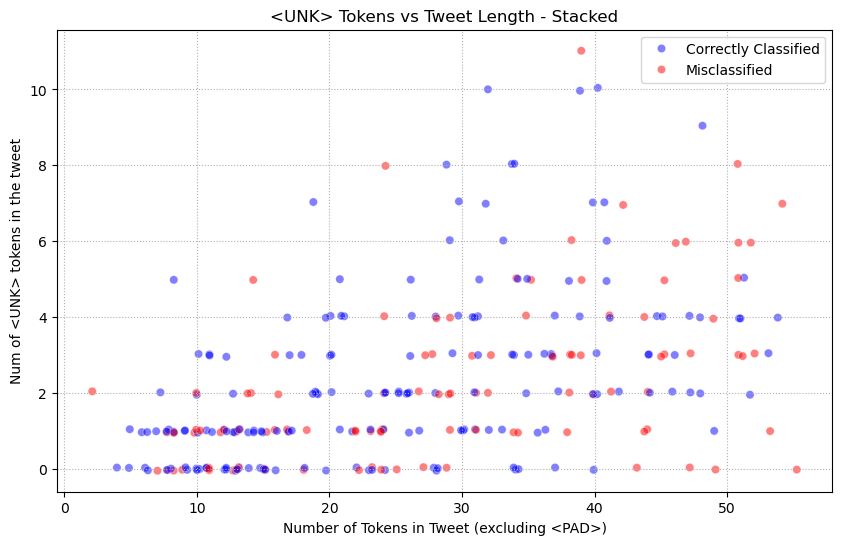

In [93]:
def count_unk_tokens_lstm(text: str, unk_token: str = "<UNK>"):
    '''
    Function to count the number of <UNK> tokens in a given text.
    '''

    return text.count(unk_token)

def count_tokens_lstm(text: str, pad_token: str = "<PAD>"):
    '''
    Function to count the number of tokens in a given text, excluding <PAD> tokens.
    '''
    tokens = text.split()
    return len(tokens)-tokens.count(pad_token)

def plot_unk_vs_length(texts, preds: np.array, true_labels: np.array, model_name: str):
    ''' 
    Function to plot the number of <UNK> tokens vs tweet length, highlighting misclassified samples.

    :param texts: list of tweet texts.
    :param preds: array of predicted class labels.
    :param true_labels: array of true class labels.
    :param model_name: name of the model for the plot title.
    '''
 
    num_unk_tokens = [count_unk_tokens_lstm(text) for text in texts]
    num_tokens = [count_tokens_lstm(text) for text in texts]
    
    perc_unk_tokens = [num / num_tokens[i] if num_tokens[i] > 0 else 0 for i, num in enumerate(num_unk_tokens)]
    
    misclassified = np.array([1 if preds[i] != true_labels[i] else 0 for i in range(len(preds))])
    
    # we add a slight perturbation to avoid overlapping points
    x_jitter = np.array(num_tokens) + np.random.uniform(-0.3, 0.3, len(num_tokens))
    y_jitter = np.array(num_unk_tokens) + np.random.uniform(-0.05, 0.05, len(num_unk_tokens))
    
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=x_jitter, y=y_jitter, hue=misclassified,
                    palette={0:'blue', 1:'red'}, alpha=0.5)
    
    plt.xlabel('Number of Tokens in Tweet (excluding <PAD>)')
    plt.ylabel('Num of <UNK> tokens in the tweet')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = ['Correctly Classified', 'Misclassified']
    plt.legend(handles=handles, labels=new_labels)
    
    plt.title(f"<UNK> Tokens vs Tweet Length - {model_name}")
    plt.grid(linestyle=':')
    plt.show()

texts = df_test_en['tweet'].tolist()  
plot_unk_vs_length(texts, baseline_ens_preds, true_labels_baseline, model_name="Baseline")
plot_unk_vs_length(texts, stacked_ens_preds, true_labels_stacked, model_name="Stacked")

The plot shows that misclassifications occur across different tweet lengths and `<UNK>` counts, suggesting that the presence of unknown tokens alone does not strongly determine classification errors.

We now move to single-words analysis. We examine which individual words are most associated with misclassifications for each class. The goal is to investigate whether there are terms that appear constantly in wrongly classified sentences, potentially revealing words that confuse the model


In [94]:
def wrong_words_plotting(true_labels: np.ndarray,predictions: np.ndarray,sentences: List[str],model_name:str,k_words=10):
    """
    Function used to plot the most misclassified examples in the test set for the specific model.

    :param true_labels: the true labels
    :param predictions: the predicted labels
    :param test_dataset: the test dataset on which to test the model
    :param model_name: the name of the model
    :param k_words: number of top words to display
    """
    sentences_tokens = [sentence.split() for sentence in sentences]
    ignore_words=set(stopwords.words('english')) | {'<pad>','<unk>','like'}
    df=pd.DataFrame({
        "sentences":sentences_tokens,
        "true_label":true_labels,
        "pred_label":predictions.astype(int)
    })
    
    n_labels=len(np.unique(true_labels))
    columns=min(2,n_labels)
    rows=math.ceil(n_labels/columns)
    
    fig,axs=plt.subplots(rows,columns,figsize=(6*columns,4*rows))
    fig.suptitle(f'{model_name} -- Most frequent words misclassified for each class')
    
    axs=axs.flatten()
    
    for label in range(n_labels):
        
        ax = axs[label]
        subset = df[df['true_label']==label]
        
        # counting all words
        all_words = Counter(word.lower() for row in subset["sentences"] 
            for word in row if word.lower() not in ignore_words)
        
        # counting the words in the misclassified samples
        df_wrong = subset[subset['true_label']!=subset['pred_label']]
        wrongest_words = Counter(word.lower() for row in df_wrong["sentences"] 
            for word in row if word.lower() not in ignore_words)
        
        # we show the top k-wrongest words per class
        top_k_wrongest_word = wrongest_words.most_common(k_words)[::-1]
        wr_words,wr_counts = zip(*top_k_wrongest_word) if top_k_wrongest_word else ([],[])
        
        # get the words for the sentences
        total_count = [all_words[word] for word in wr_words]
        
        y_pos = range(len(wr_words))
        
        # barchart creation
        ax.barh(y_pos,total_count,color="lightblue",alpha=0.6,label='All Sentences')
        ax.barh(y_pos,wr_counts,color="red",alpha=0.8,label='Misclassified')
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(wr_words)
        ax.set_xlabel('Word frequency')
        ax.set_title(f"Misclassified words for label '{list(mapping.keys())[label]}'")
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend()
        ax.grid(axis='x')
    
    plt.tight_layout()
    plt.show()

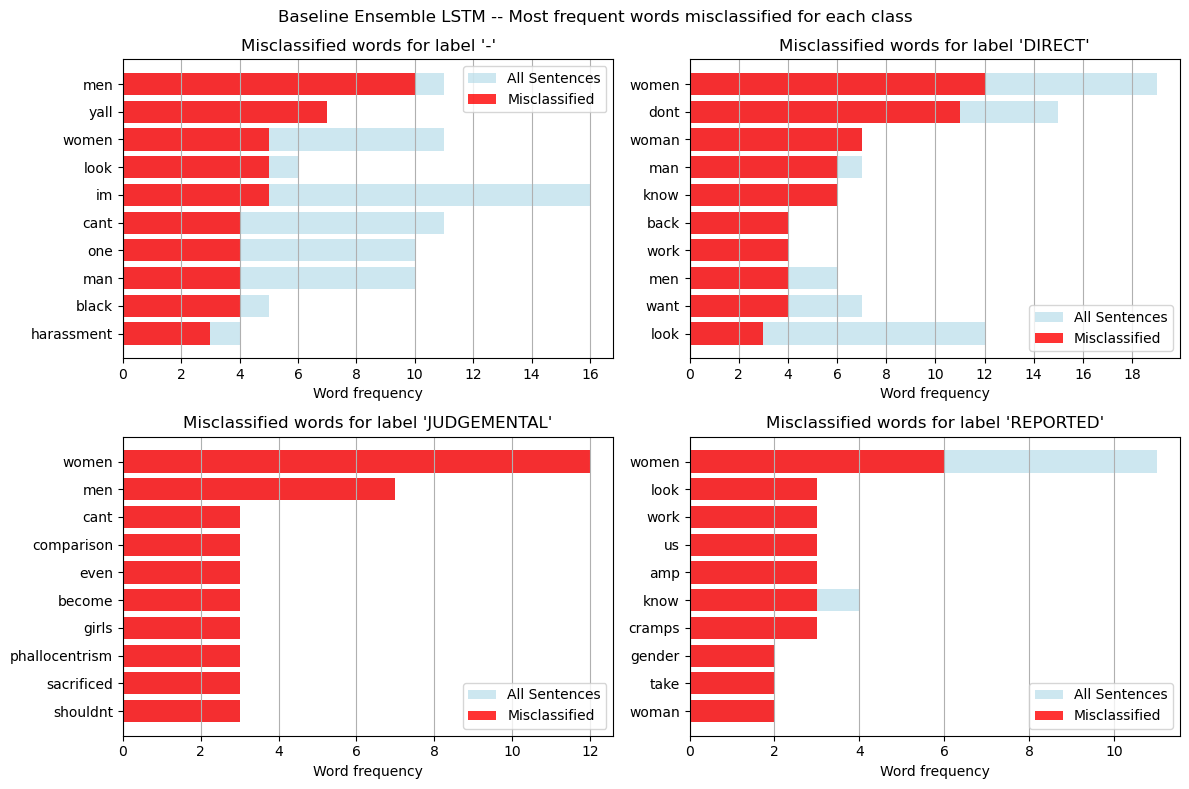

In [95]:
sentences = [row['tweet_clean'] for row in test_dataset_transformer]
wrong_words_plotting(
    true_labels=true_labels_baseline,
    predictions=baseline_ens_preds,
    sentences=sentences,
    model_name="Baseline Ensemble LSTM",
)

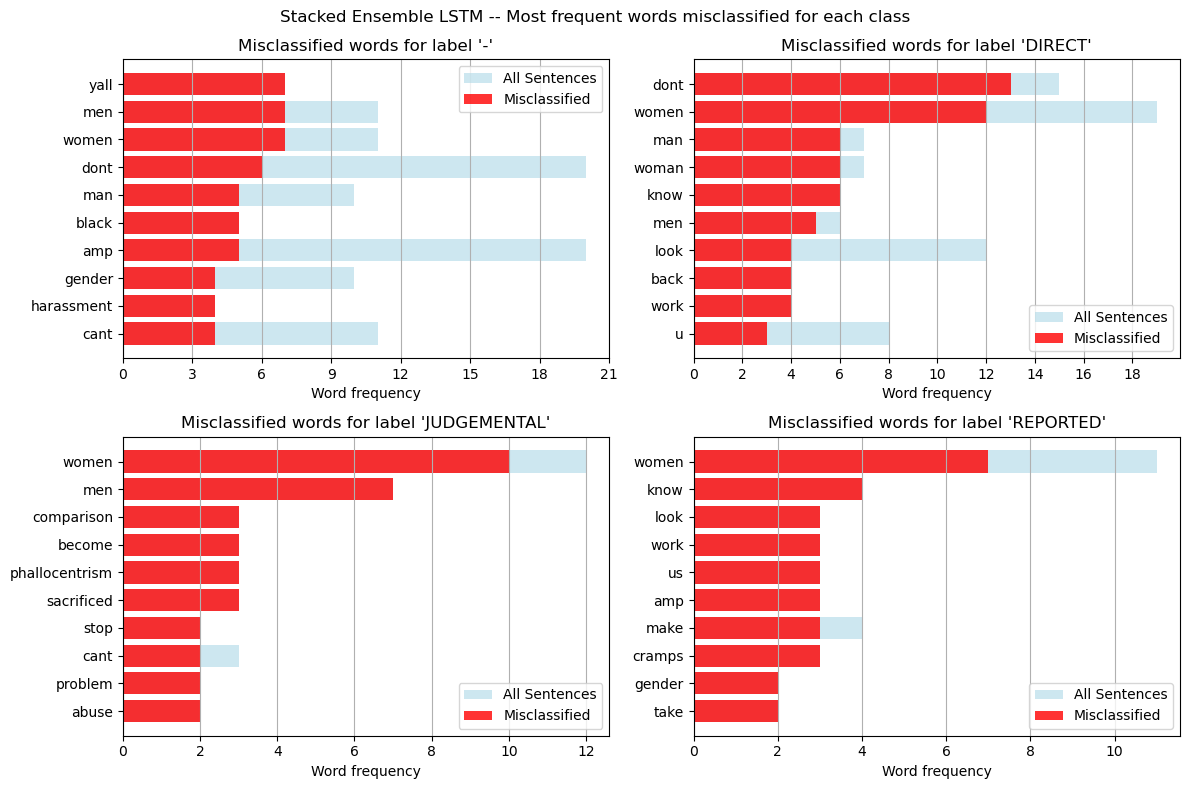

In [96]:
wrong_words_plotting(
    true_labels=true_labels_stacked,
    predictions=stacked_ens_preds,
    sentences=sentences,
    model_name="Stacked Ensemble LSTM",
)

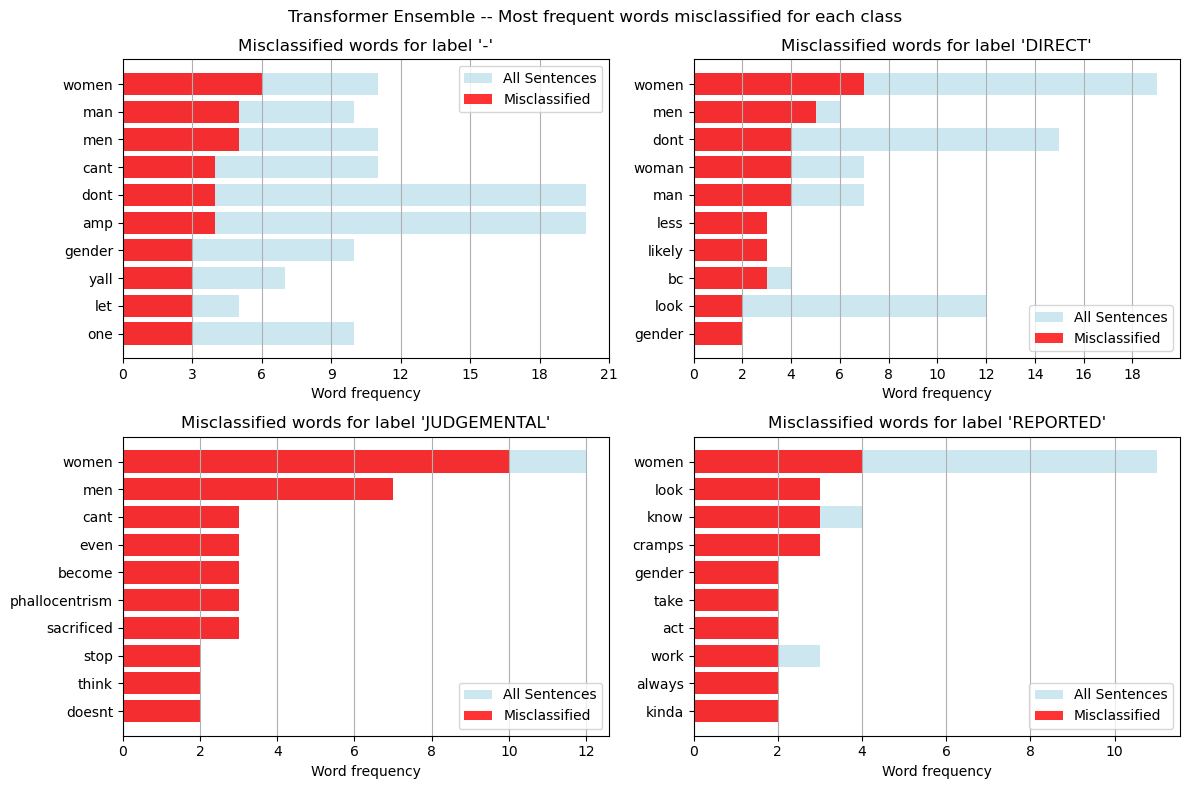

In [97]:
wrong_words_plotting(
    true_labels=true_labels_transformer,
    predictions=transformer_ens_preds,
    sentences=sentences,
    model_name="Transformer Ensemble"
)

Finally, we analyze whether sentence length played a role in misclassification. To do this, we compare the number of sentences of each length with the number of sentences misclassified for that length.


In [98]:
def plot_len_sentences(
    model_predictions: np.ndarray,
    true_labels: np.ndarray,
    sentences: List[List[str]],
    model_name: str) -> None:
    """
    Function to plot the length of the wrong classified sentences for each label and print the correlation.

    :param model_predictions: predictions of the model (np.ndarray)
    :param true_labels: true labels (np.ndarray)
    :param sentences: input sentences (list)
    :param model_name: name of the model for the plot title (str)
    """
    # we first remove the padding
    sentence_without_tokens=[]
    for row in sentences:
        filtered_sentence=[word for word in row if word not in ['<PAD>']]
        sentence_without_tokens.append(filtered_sentence)

    df = pd.DataFrame({"sentences": list(sentence_without_tokens)})
    df["true_label"]=true_labels
    df["pred_label"]=model_predictions.astype(int)

    # we get the wrong classified sentences and count them based on length
    df_wrong = df[df["true_label"]!= df["pred_label"]]
    len_sentences_wrong = Counter([len(row) for row in df_wrong["sentences"]])
    len_sentences = Counter([len(row) for row in df["sentences"]])

    # we zip the lengths and counts for plotting phase
    tot_lengths,tot_counts = zip(*len_sentences.items())
    wrong_lengths,wrong_counts = zip(*len_sentences_wrong.items())
    
    plt.bar(tot_lengths,tot_counts,alpha=0.6,color="lightblue",label="All Sentences")
    plt.bar(wrong_lengths,wrong_counts,alpha=0.8, color="red",label="Misclassified")
    plt.title(f"Length of {model_name} wrong sentences")
    plt.xlabel("Sentence length")
    plt.ylabel("Number of sentences")
    plt.legend()
    plt.show()


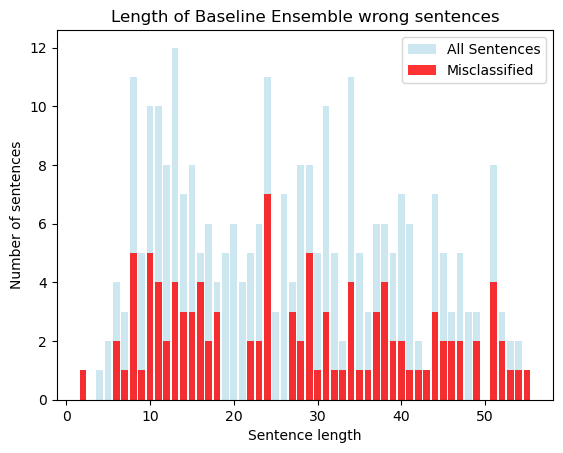

In [99]:
sentences_from_dataset = [tweet.split() for tweet in df_test_en['tweet'].tolist()]

plot_len_sentences(
    model_predictions=baseline_ens_preds,
    true_labels=true_labels_baseline,
    sentences=sentences_from_dataset,
    model_name="Baseline Ensemble"
)

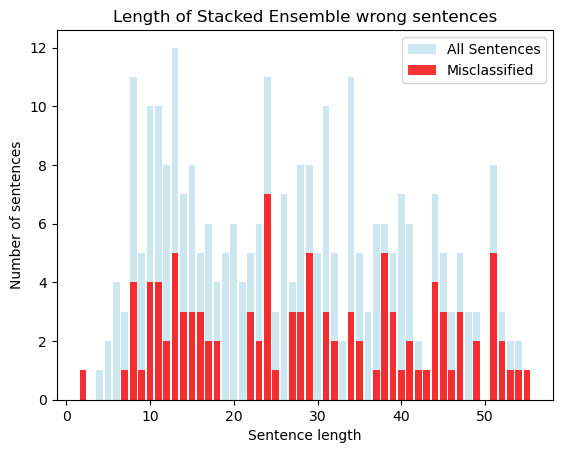

In [100]:
plot_len_sentences(
    model_predictions=stacked_ens_preds,
    true_labels=true_labels_stacked,
    sentences=sentences_from_dataset,
    model_name="Stacked Ensemble"
)

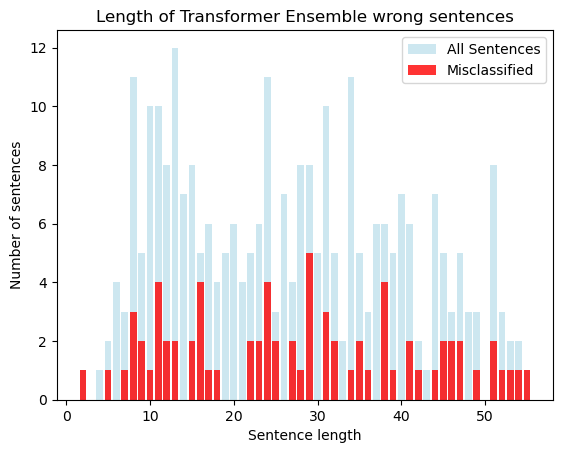

In [101]:
plot_len_sentences(
    model_predictions=transformer_ens_preds,
    true_labels=true_labels_transformer,
    sentences=sentences_from_dataset,
    model_name="Transformer Ensemble"
)

As we can see, the percentage of misclassified tweets relative to the total number of tweets for each length remains approximately constant across all three models, suggesting that sentence length does not significantly affect the models ability to classify correctly.


## Bonus Points

Here we display the results obtained by computing the embedding of the OOV with the mean over the top-k words and the weighted average over the top-k words.

The values chosen are:

**k** = 2

**weights** = [0.7,0.3]

## Mean top-k words

In [102]:
emb_matrix_mean, _ = build_embedding_matrix(embedding_model, cfg["embedding_dimension"], word_to_idx, "mean")
emb_weights_mean = torch.tensor(emb_matrix_mean, dtype=torch.float32)

100%|██████████| 9810/9810 [00:46<00:00, 209.47it/s]


In [103]:
baseline_factory_mean = lambda: lstm_model_factory(cfg["embedding_dimension"], emb_weights_mean, 1, cfg["max_sequence_length"], cfg["num_labels"], cfg["TRAINING_CONFIGURATION_LSTM"])
stacked_factory_mean = lambda: lstm_model_factory(cfg["embedding_dimension"], emb_weights_mean, 2, cfg["max_sequence_length"], cfg["num_labels"], cfg["TRAINING_CONFIGURATION_LSTM"])

baseline_model_metrics_mean, baseline_chart_data_mean = train_LSTM_multiple_seeds(
    baseline_factory_mean, "baseline", train_loader_lstm, val_loader_lstm, test_loader_lstm, cfg["TRAINING_CONFIGURATION_LSTM"] , cfg["seeds"], cfg["weights_path"]
)

stacked_model_metrics_mean, stacked_chart_data_mean = train_LSTM_multiple_seeds(
    stacked_factory_mean, "stacked", train_loader_lstm, val_loader_lstm, test_loader_lstm, cfg["TRAINING_CONFIGURATION_LSTM"], cfg["seeds"], cfg["weights_path"]
)

Training stacked model (seed=43): 100%|██████████| 120/120 [00:27<00:00,  4.35it/s]


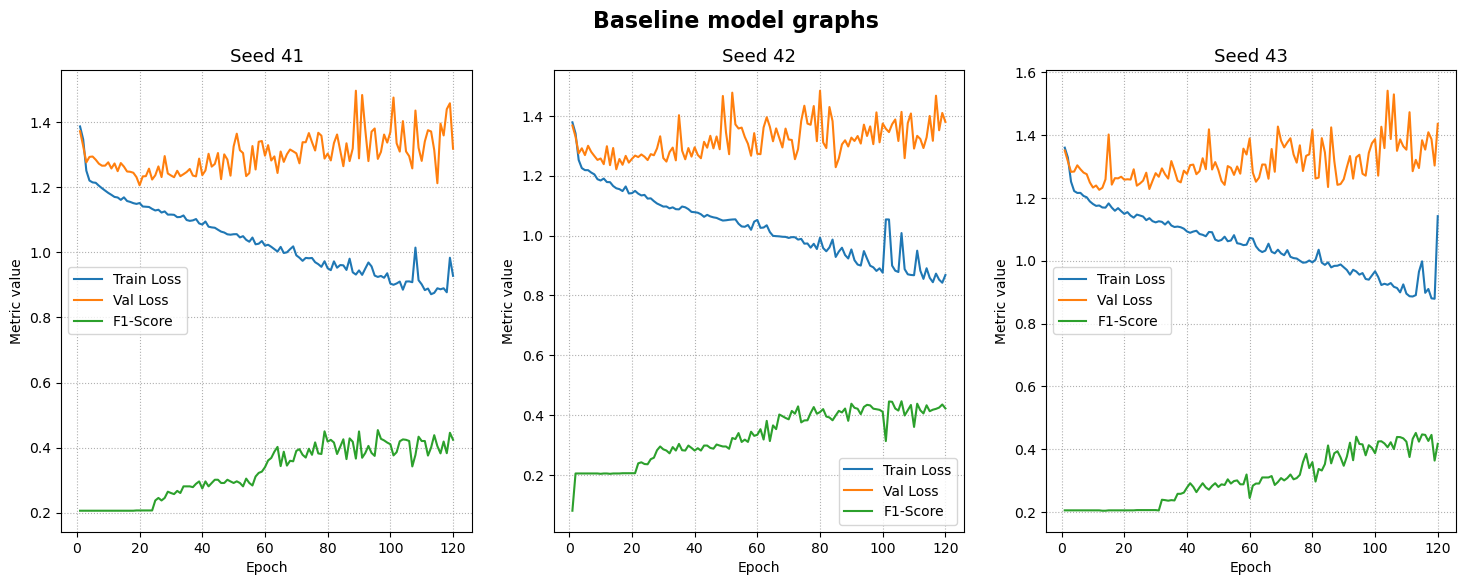

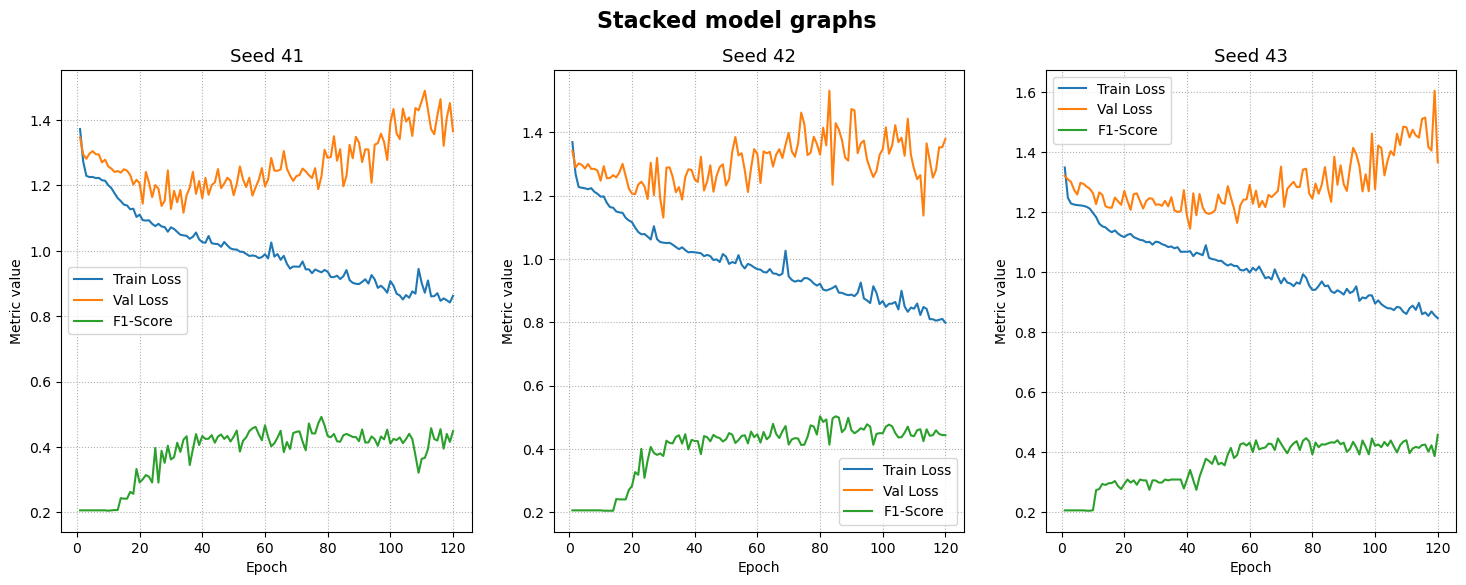

,val_precision,val_recall,val_f1-score,test_precision,test_recall,test_f1-score
41,0.41,0.44,0.42,0.34,0.36,0.35
42,0.41,0.45,0.42,0.33,0.36,0.34
43,0.43,0.44,0.42,0.35,0.35,0.34


,val_precision,val_recall,val_f1-score,test_precision,test_recall,test_f1-score
41,0.43,0.47,0.45,0.37,0.39,0.38
42,0.47,0.43,0.44,0.42,0.40,0.40
43,0.45,0.49,0.46,0.43,0.43,0.41


In [104]:
plot_model_data(baseline_chart_data_mean,np.arange(1, cfg["TRAINING_CONFIGURATION_LSTM"]["epochs"]+1),"Baseline model graphs", cfg["seeds"])
plot_model_data(stacked_chart_data_mean,np.arange(1, cfg["TRAINING_CONFIGURATION_LSTM"]["epochs"]+1),"Stacked model graphs", cfg["seeds"])

display(baseline_model_metrics_mean.style.format(precision=2).set_caption("<h3>Baseline model metrics</h3>"))
display(stacked_model_metrics_mean.style.format(precision=2).set_caption("<h3>Stacked model metrics</h3>"))

The results indicate that computing OOV embeddings randomly yields significantly greater stability across seeds and a superior F1-score compared to using the mean of the top-k neighbors.

## Weighted average top-k words

In [105]:
emb_matrix_avg, word_to_emb = build_embedding_matrix(embedding_model, cfg["embedding_dimension"], word_to_idx, "average")
emb_weights_avg = torch.tensor(emb_matrix_avg, dtype=torch.float32)

100%|██████████| 9810/9810 [00:44<00:00, 219.34it/s]


In [106]:
baseline_factory_avg = lambda: lstm_model_factory(cfg["embedding_dimension"], emb_weights_avg, 1, cfg["max_sequence_length"], cfg["num_labels"], cfg["TRAINING_CONFIGURATION_LSTM"])
stacked_factory_avg = lambda: lstm_model_factory(cfg["embedding_dimension"], emb_weights_avg, 2, cfg["max_sequence_length"], cfg["num_labels"], cfg["TRAINING_CONFIGURATION_LSTM"])

baseline_model_metrics_avg, baseline_chart_data_avg = train_LSTM_multiple_seeds(
    baseline_factory_avg, "baseline", train_loader_lstm, val_loader_lstm, test_loader_lstm, cfg["TRAINING_CONFIGURATION_LSTM"] , cfg["seeds"], cfg["weights_path"]
)

stacked_model_metrics_avg, stacked_chart_data_avg = train_LSTM_multiple_seeds(
    stacked_factory_avg, "stacked", train_loader_lstm, val_loader_lstm, test_loader_lstm, cfg["TRAINING_CONFIGURATION_LSTM"], cfg["seeds"], cfg["weights_path"]
)

Training stacked model (seed=43): 100%|██████████| 120/120 [00:26<00:00,  4.57it/s]


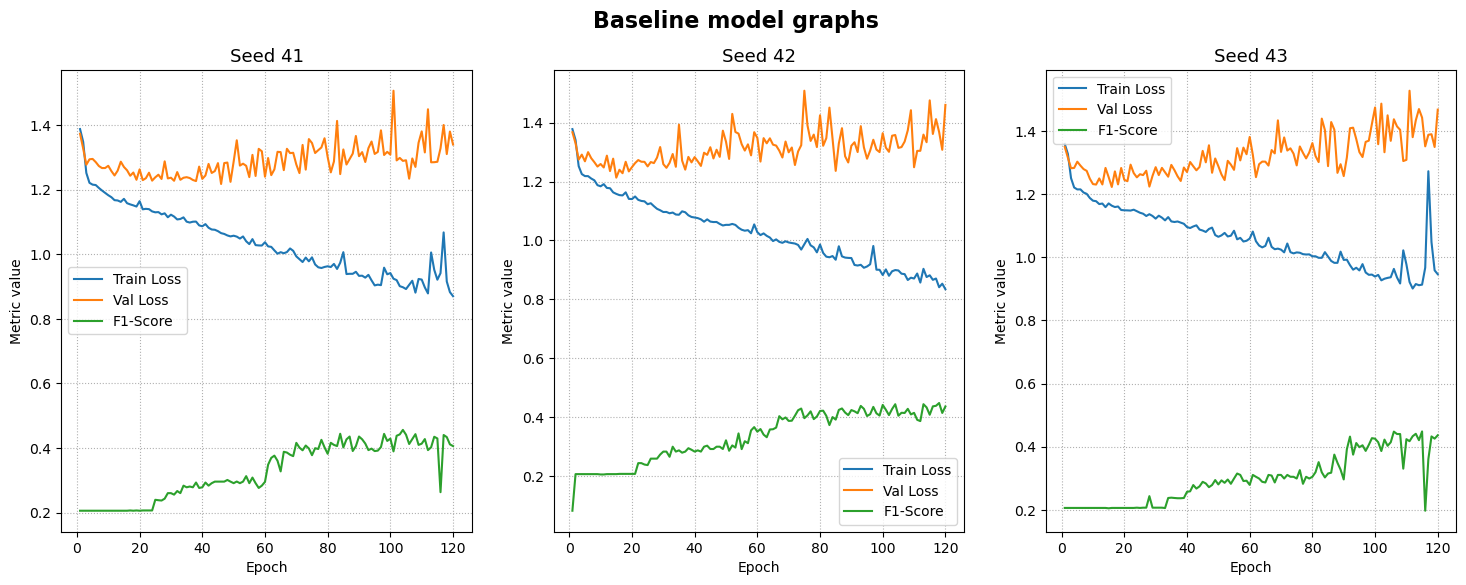

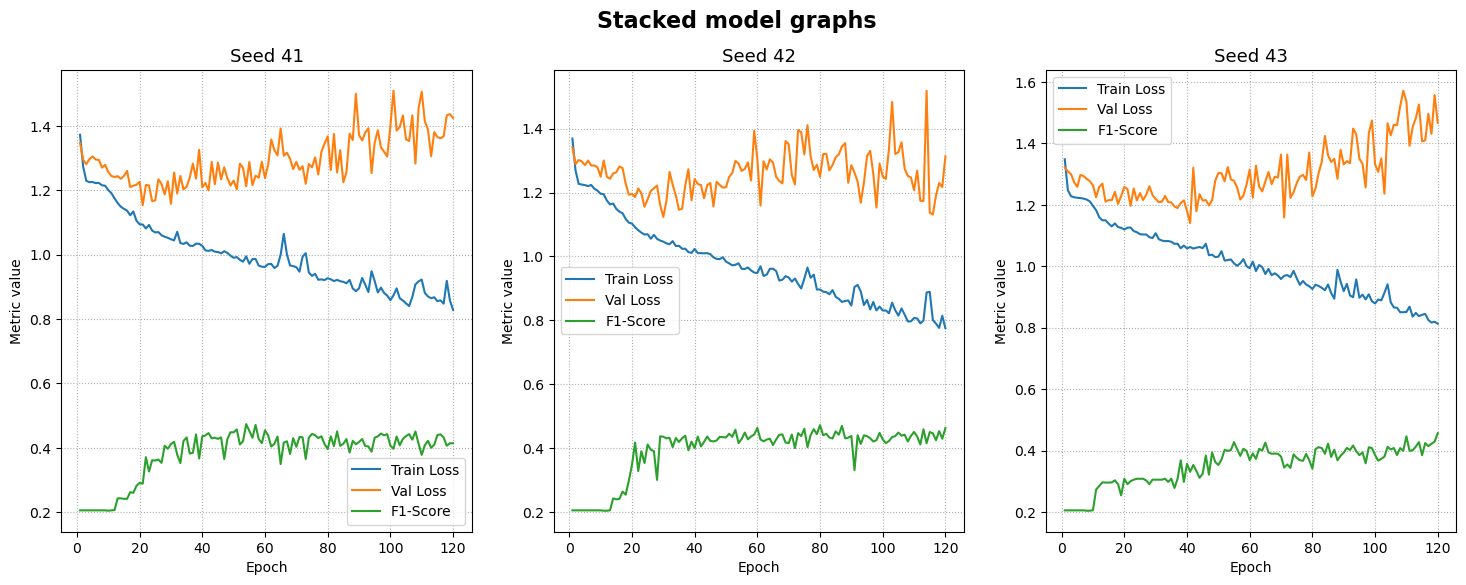

,val_precision,val_recall,val_f1-score,test_precision,test_recall,test_f1-score
41,0.39,0.42,0.41,0.32,0.34,0.33
42,0.42,0.46,0.44,0.34,0.36,0.35
43,0.45,0.43,0.44,0.33,0.34,0.33


,val_precision,val_recall,val_f1-score,test_precision,test_recall,test_f1-score
41,0.42,0.42,0.41,0.35,0.37,0.36
42,0.48,0.46,0.46,0.41,0.41,0.40
43,0.46,0.47,0.46,0.40,0.41,0.40


In [107]:
plot_model_data(baseline_chart_data_avg,np.arange(1, cfg["TRAINING_CONFIGURATION_LSTM"]["epochs"]+1),"Baseline model graphs", cfg["seeds"])
plot_model_data(stacked_chart_data_avg,np.arange(1, cfg["TRAINING_CONFIGURATION_LSTM"]["epochs"]+1),"Stacked model graphs", cfg["seeds"])

display(baseline_model_metrics_avg.style.format(precision=2).set_caption("<h3>Baseline model metrics</h3>"))
display(stacked_model_metrics_avg.style.format(precision=2).set_caption("<h3>Stacked model metrics</h3>"))

The results obtained by computing OOV embeddings through the weighted average of top-k words indicate that prioritizing the nearest neighbors results in minimal performance gains